## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString

from collections import defaultdict
import json
import os
import re
import contextily as cx

In [2]:
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Global relationships

## Sankey Diagrams

In [3]:
# Create output directory
os.makedirs('plots', exist_ok=True)

# Load the data
df = pd.read_csv('all_regions_combined_v3.csv')
print(f"Loaded dataset with {len(df)} rows")

# Parse storm intensities and calculate storm pressure (impact)
def parse_storm_intensities(intensity_str):
    if pd.isna(intensity_str) or intensity_str == 'none':
        return []
    # Extract numbers from the string using regex
    numbers = re.findall(r'-?\d+\.?\d*', str(intensity_str))
    if numbers:
        return [float(num) for num in numbers]
    return []

df['storm_intensities_list'] = df['storm_intensities'].apply(parse_storm_intensities)

# # NEW CALCULATION: Calculate storm pressure as sum of log(intensity + 0.1)
# def calculate_log_storm_pressure(intensities):
#     if not intensities:
#         return 0
#     # Calculate sum of log(intensity + 0.1) for each intensity
#     return sum(np.log10(intensity + 0.1) for intensity in intensities)

# df['storm_pressure'] = df['storm_intensities_list'].apply(calculate_log_storm_pressure)

# NEW CALCULATION: Calculate storm pressure as sum of exp(intensity)
def calculate_exp_storm_pressure(intensities):
    if not intensities:
        return 0
    # Calculate sum of exp(intensity) for each intensity
    return sum(np.exp(intensity) for intensity in intensities)

df['storm_pressure'] = df['storm_intensities_list'].apply(calculate_exp_storm_pressure)


# Determine habitat presence and diversity
threshold = 0.01  # Minimal area to consider a habitat present
df['has_mangrove'] = df['mangrove_area_km2_2015'] > threshold
df['has_seagrass'] = df['seagrass_area_km2_2015'] > threshold
df['has_reef'] = df['reef_area_km2_2015'] > threshold

# Count habitat diversity (1, 2, or 3 types)
df['habitat_diversity'] = df['has_mangrove'].astype(int) + df['has_seagrass'].astype(int) + df['has_reef'].astype(int)

# Create habitat combination variable (m, s, r, ms, mr, sr, msr)
def get_habitat_combination(row):
    combo = ""
    if row['has_mangrove']: combo += "m"
    if row['has_seagrass']: combo += "s"
    if row['has_reef']: combo += "r"
    return combo if combo else "none"

df['habitat_combination'] = df.apply(get_habitat_combination, axis=1)

# Remove data with zero habitat diversity
df = df[df['habitat_diversity'] > 0]
print(f"Remaining rows after removing zero habitat diversity: {len(df)}")

# Calculate resilience metrics for each habitat type
for habitat in ['mangrove', 'reef', 'seagrass']:
    # Initial and final areas
    initial_col = f'{habitat}_area_km2_2015'
    final_col = f'{habitat}_area_km2_2020'
    
    # Only calculate for areas where habitat exists
    has_habitat = df[f'has_{habitat}']
    
    # Initialize columns
    df[f'{habitat}_absolute_change'] = np.nan
    df[f'{habitat}_percent_change'] = np.nan
    df[f'{habitat}_is_resilient'] = np.nan
    
    # Calculate for grid cells where the habitat exists
    mask = has_habitat
    
    # Absolute change
    df.loc[mask, f'{habitat}_absolute_change'] = df.loc[mask, final_col] - df.loc[mask, initial_col]
    
    # Percent change (avoid div by zero)
    non_zero_mask = (mask) & (df[initial_col] > 0)
    df.loc[non_zero_mask, f'{habitat}_percent_change'] = (
        (df.loc[non_zero_mask, final_col] - df.loc[non_zero_mask, initial_col]) / 
        df.loc[non_zero_mask, initial_col] * 100
    )
    
    # Binary resilience (1 if maintained or increased, 0 if decreased)
    df.loc[mask, f'{habitat}_is_resilient'] = (df.loc[mask, final_col] >= df.loc[mask, initial_col]).astype(int)

# Calculate overall ecosystem resilience
df['total_initial_area'] = (
    df['mangrove_area_km2_2015'].fillna(0) + 
    df['reef_area_km2_2015'].fillna(0) + 
    df['seagrass_area_km2_2015'].fillna(0)
)

df['total_final_area'] = (
    df['mangrove_area_km2_2020'].fillna(0) + 
    df['reef_area_km2_2020'].fillna(0) + 
    df['seagrass_area_km2_2020'].fillna(0)
)

# Overall absolute change
df['overall_absolute_change'] = df['total_final_area'] - df['total_initial_area']

# Overall percent change (avoid div by zero)
non_zero_mask = df['total_initial_area'] > 0
df.loc[non_zero_mask, 'overall_percent_change'] = (
    (df.loc[non_zero_mask, 'total_final_area'] - df.loc[non_zero_mask, 'total_initial_area']) / 
    df.loc[non_zero_mask, 'total_initial_area'] * 100
)

# Binary overall resilience
df['overall_is_resilient'] = (df['total_final_area'] >= df['total_initial_area']).astype(int)

# Improved outlier removal function to avoid warnings
def remove_outliers(df, columns, n_std=3):
    """Remove outliers that are more than n_std standard deviations from the mean"""
    df_clean = df.copy()
    
    # Track indices to remove
    indices_to_remove = set()
    
    # Only apply to numeric columns
    numeric_cols = [col for col in columns if np.issubdtype(df[col].dtype, np.number)]
    
    for col in numeric_cols:
        if df[col].notnull().any():  # Skip columns that are all null
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - n_std * std
            upper_bound = mean + n_std * std
            
            # Find outlier indices
            outlier_indices = df.index[
                (df[col] < lower_bound) | (df[col] > upper_bound)
            ].tolist()
            
            if outlier_indices:
                print(f"Found {len(outlier_indices)} outliers in {col}")
                indices_to_remove.update(outlier_indices)
    
    # Remove all identified outliers at once
    if indices_to_remove:
        print(f"Removing {len(indices_to_remove)} total outliers")
        df_clean = df_clean.drop(index=list(indices_to_remove))
    
    return df_clean

# List of columns to check for outliers
outlier_columns = [
    'overall_percent_change', 
    'mangrove_percent_change', 
    'reef_percent_change', 
    'seagrass_percent_change',
    'storm_pressure',
    'total_initial_area'
]

# Apply outlier removal
df_clean = remove_outliers(df, outlier_columns, n_std=3)
print(f"Remaining rows after outlier removal: {len(df_clean)}")

# Update the dataframe for further analysis
df = df_clean

# Create categorized variables for Sankey diagram
# 1. Categorize habitat combinations
combo_map = {
    'm': 'Mangrove Only',
    's': 'Seagrass Only',
    'r': 'Reef Only',
    'ms': 'Mangrove+Seagrass',
    'mr': 'Mangrove+Reef',
    'sr': 'Seagrass+Reef',
    'msr': 'All Three Habitats'
}
df['combo_label'] = df['habitat_combination'].map(combo_map)

# 2. Categorize diversity levels
diversity_map = {
    1: '1 Habitat Type',
    2: '2 Habitat Types',
    3: '3 Habitat Types'
}
df['diversity_label'] = df['habitat_diversity'].map(diversity_map)

# 3. Categorize resilience outcomes
df['resilience_category'] = pd.cut(
    df['overall_percent_change'],
    bins=[-float('inf'), -10, 10, float('inf')],
    labels=['Decreased (>10%)', 'Stable (±10%)', 'Increased (>10%)']
)

# 4. Categorize storm pressure - FIX FOR DUPLICATE BINS
# First check the storm pressure distribution
print("\nStorm pressure statistics:")
print(f"Min: {df['storm_pressure'].min()}")
print(f"25%: {df['storm_pressure'].quantile(0.25)}")
print(f"Median: {df['storm_pressure'].median()}")
print(f"75%: {df['storm_pressure'].quantile(0.75)}")
print(f"Max: {df['storm_pressure'].max()}")
print(f"Zero values: {(df['storm_pressure'] == 0).sum()}")

# Create storm pressure categories based on the data distribution
if df['storm_pressure'].nunique() <= 1:
    # If there's only one value (or all values are the same)
    df['storm_pressure_category'] = 'No Variation in Storm Pressure'
elif df['storm_pressure'].median() == 0:
    # If median is 0, use a different approach
    # Use 75th percentile instead of median
    storm_75th = df['storm_pressure'].quantile(0.75)
    if storm_75th > 0:
        df['storm_pressure_category'] = pd.cut(
            df['storm_pressure'],
            bins=[-float('inf'), 0, storm_75th, float('inf')],
            labels=['No Storm', 'Low Storm', 'High Storm']
        )
    else:
        # If 75th percentile is also 0, use a simple binary categorization
        df['storm_pressure_category'] = np.where(
            df['storm_pressure'] > 0, 'Has Storm', 'No Storm'
        )
else:
    # Use the original approach with median
    storm_median = df['storm_pressure'].median()
    df['storm_pressure_category'] = pd.cut(
        df['storm_pressure'],
        bins=[-float('inf'), 0, storm_median, float('inf')],
        labels=['No Storm', 'Low Storm', 'High Storm']
    )

# Print the distribution of storm pressure categories
print("\nStorm pressure category distribution:")
print(df['storm_pressure_category'].value_counts())

# Define the unique node labels for each category
combo_nodes = list(combo_map.values())
diversity_nodes = list(diversity_map.values())
resilience_nodes = ['Decreased (>10%)', 'Stable (±10%)', 'Increased (>10%)']
storm_nodes = df['storm_pressure_category'].unique().tolist()

# Combine all nodes
all_nodes = combo_nodes + diversity_nodes + resilience_nodes + storm_nodes

# Create node indices dictionary
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Define color palette with requested colors
# MODIFIED: Updated color palettes according to specifications
# Habitat combination colors - base colors: mangrove-yellow, reef-magenta, seagrass-cyan
# For combinations, we'll mix the colors
combo_colors = {
    'Mangrove Only': '#FFFF00',      # Yellow
    'Seagrass Only': '#00FFFF',      # Cyan
    'Reef Only': '#FF00FF',          # Magenta
    'Mangrove+Seagrass': '#80FF80',  # Yellow + Cyan mix
    'Mangrove+Reef': '#FF80FF',      # Yellow + Magenta mix
    'Seagrass+Reef': '#7F7FFF',      # More balanced Cyan + Magenta mix (blueish-purple)
    'All Three Habitats': '#C0C0C0'   # Mix of all three
}
combo_colors = [combo_colors[node] for node in combo_nodes]

# MODIFIED: Diversity colors as specified
diversity_colors = {
    '1 Habitat Type': '#EECC66',
    '2 Habitat Types': '#994455',
    '3 Habitat Types': '#000000'
}
diversity_colors = [diversity_colors[node] for node in diversity_nodes]

# MODIFIED: Resilience colors as specified
resilience_colors = {
    'Stable (±10%)': '#808080',      # Gray
    'Increased (>10%)': '#00008B',   # Dark blue 
    'Decreased (>10%)': '#8B0000'    # Dark red
}
resilience_colors = [resilience_colors[node] for node in resilience_nodes]

# # Storm colors - using viridis color palette
# import matplotlib.pyplot as plt
# from matplotlib.colors import to_hex
# # Get colors from viridis palette based on number of storm nodes
# viridis_cmap = plt.cm.viridis
# storm_colors = [to_hex(viridis_cmap(i/(len(storm_nodes)-1 if len(storm_nodes) > 1 else 1))) for i in range(len(storm_nodes))]

storm_colors = ['#440154', '#2A788E', '#7ad151']  # Colors for No Storm, Low, High

# Combine all colors
all_colors = combo_colors + diversity_colors + resilience_colors + storm_colors

# Create lists to store the source, target, and value for each link
sources = []
targets = []
values = []
link_colors = []

# 1. Links from Habitat Combination to Diversity Level
for combo in combo_map:
    combo_label = combo_map[combo]
    source_idx = node_indices[combo_label]
    
    # Calculate the diversity level for this combination
    diversity = len(combo)
    diversity_label = diversity_map[diversity]
    target_idx = node_indices[diversity_label]
    
    # Count the number of cells with this combination
    value = len(df[df['habitat_combination'] == combo])
    
    if value > 0:
        sources.append(source_idx)
        targets.append(target_idx)
        values.append(value)
        link_colors.append(combo_colors[list(combo_map.values()).index(combo_label)])

# 2. Links from Diversity Level to Resilience Outcome
for div in diversity_map:
    div_label = diversity_map[div]
    source_idx = node_indices[div_label]
    
    for res_cat in resilience_nodes:
        target_idx = node_indices[res_cat]
        
        # Count cells with this diversity level and resilience outcome
        value = len(df[(df['habitat_diversity'] == div) & (df['resilience_category'] == res_cat)])
        
        if value > 0:
            sources.append(source_idx)
            targets.append(target_idx)
            values.append(value)
            link_colors.append(diversity_colors[list(diversity_map.values()).index(div_label)])

# 3. Links from Resilience Outcome to Storm Pressure Category
for res_cat in resilience_nodes:
    source_idx = node_indices[res_cat]
    
    for storm_cat in storm_nodes:
        target_idx = node_indices[storm_cat]
        
        # Count cells with this resilience outcome and storm category
        value = len(df[(df['resilience_category'] == res_cat) & (df['storm_pressure_category'] == storm_cat)])
        
        if value > 0:
            sources.append(source_idx)
            targets.append(target_idx)
            values.append(value)
            link_colors.append(resilience_colors[resilience_nodes.index(res_cat)])

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = all_nodes,
        color = all_colors
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values,
        color = link_colors
    )
)])

# Update the layout
fig.update_layout(
    title_text=None,  # Remove title
    font=dict(
        family="Helvetica, Arial, sans-serif",
        size=18,  # Slightly bigger font
        color="black"
    ),
    width=1200,
    height=800
)

# Make the node labels bold by modifying the node text
fig.data[0].node.label = [f'<b>{label}</b>' for label in all_nodes]

# MODIFIED: Remove HTML output, keep only PNG
fig.write_image("plots/habitat_sankey_diagram_v4.png") #scale=2
print("Saved first Sankey diagram as PNG")


# Replace the existing size categorization code with this updated version

# Create a second Sankey diagram focusing on initial size and resilience
# Add size categories with the specified thresholds
df_size = df.copy()

# Define the custom bins for area categories
area_bins = [0, 2, 5, 15, float('inf')]
area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
               'Medium-Large (5-15 km²)', 'Large (> 15 km²)']

# Create the categorical variable using the custom bins
df_size['size_category'] = pd.cut(
    df_size['total_initial_area'],
    bins=area_bins,
    labels=area_labels,
    right=False  # Intervals are left-inclusive and right-exclusive
)

# Print the distribution of size categories
print("\nDistribution of habitat size categories:")
print(df_size['size_category'].value_counts())
print(df_size['size_category'].value_counts(normalize=True).round(3) * 100, "%")

# Define nodes for the size-focused diagram
diversity_nodes = list(diversity_map.values())
size_nodes = list(area_labels)  # Use the predefined labels in order
resilience_nodes = ['Decreased (>10%)', 'Stable (±10%)', 'Increased (>10%)']
storm_nodes = df['storm_pressure_category'].unique().tolist()

# Combine all nodes
all_nodes_size = diversity_nodes + size_nodes + resilience_nodes + storm_nodes

# Create node indices dictionary
node_indices_size = {node: i for i, node in enumerate(all_nodes_size)}

# Define color palette
# MODIFIED: Use the same diversity colors as the first diagram
diversity_colors_dict = {
    '1 Habitat Type': '#EECC66',
    '2 Habitat Types': '#994455',
    '3 Habitat Types': '#000000'
}
diversity_colors = [diversity_colors_dict[node] for node in diversity_nodes]

# Use a color gradient for size categories from light to dark blue
size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e'][:len(size_nodes)]

# MODIFIED: Use the same resilience colors as the first diagram
resilience_colors_dict = {
    'Stable (±10%)': '#808080',      # Gray
    'Increased (>10%)': '#00008B',   # Dark blue 
    'Decreased (>10%)': '#8B0000'    # Dark red
}
resilience_colors = [resilience_colors_dict[node] for node in resilience_nodes]

# # Storm colors - using viridis color palette
# import matplotlib.pyplot as plt
# from matplotlib.colors import to_hex
# # Get colors from viridis palette based on number of storm nodes
# viridis_cmap = plt.cm.viridis
# storm_colors = [to_hex(viridis_cmap(i/(len(storm_nodes)-1 if len(storm_nodes) > 1 else 1))) for i in range(len(storm_nodes))]
storm_colors = ['#440154', '#2A788E', '#7ad151']  # Colors for No Storm, Low, High

# Combine all colors
all_colors_size = diversity_colors + size_colors + resilience_colors + storm_colors

# Create lists to store the source, target, and value for each link
sources_size = []
targets_size = []
values_size = []
link_colors_size = []

# 1. Links from Diversity Level to Size Category
for div in diversity_map:
    div_label = diversity_map[div]
    source_idx = node_indices_size[div_label]
    
    for size_cat in size_nodes:
        target_idx = node_indices_size[size_cat]
        
        # Count cells with this diversity level and size category
        value = len(df_size[(df_size['habitat_diversity'] == div) & (df_size['size_category'] == size_cat)])
        
        if value > 0:
            sources_size.append(source_idx)
            targets_size.append(target_idx)
            values_size.append(value)
            link_colors_size.append(diversity_colors[list(diversity_map.values()).index(div_label)])

# 2. Links from Size Category to Resilience Outcome
for size_cat in size_nodes:
    source_idx = node_indices_size[size_cat]
    
    for res_cat in resilience_nodes:
        target_idx = node_indices_size[res_cat]
        
        # Count cells with this size category and resilience outcome
        value = len(df_size[(df_size['size_category'] == size_cat) & (df_size['resilience_category'] == res_cat)])
        
        if value > 0:
            sources_size.append(source_idx)
            targets_size.append(target_idx)
            values_size.append(value)
            link_colors_size.append(size_colors[size_nodes.index(size_cat)])

# 3. Links from Resilience Outcome to Storm Pressure Category
for res_cat in resilience_nodes:
    source_idx = node_indices_size[res_cat]
    
    for storm_cat in storm_nodes:
        target_idx = node_indices_size[storm_cat]
        
        # Count cells with this resilience outcome and storm category
        value = len(df_size[(df_size['resilience_category'] == res_cat) & (df_size['storm_pressure_category'] == storm_cat)])
        
        if value > 0:
            sources_size.append(source_idx)
            targets_size.append(target_idx)
            values_size.append(value)
            link_colors_size.append(resilience_colors[resilience_nodes.index(res_cat)])

# Create the second Sankey diagram
fig_size = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = all_nodes_size,
        color = all_colors_size
    ),
    link = dict(
        source = sources_size,
        target = targets_size,
        value = values_size,
        color = link_colors_size
    )
)])

# Update the layout
fig_size.update_layout(
    title_text=None,  # Remove title
    font=dict(
        family="Helvetica, Arial, sans-serif",
        size=18,  # Slightly bigger font
        color="black"
    ),
    width=1200,
    height=800
)

# Make the node labels bold by modifying the node text
fig_size.data[0].node.label = [f'<b>{label}</b>' for label in all_nodes_size]

# Save the second Sankey diagram
fig_size.write_image("plots/habitat_size_sankey_diagram_v4.png" ) #scale=2
print("Saved second Sankey diagram with updated size categories as PNG")

# Create a summary table of the relationships with new size categories
# Summary of size categories and resilience
size_resilience = pd.crosstab(
    df_size['size_category'], 
    df_size['resilience_category'], 
    normalize='index'
) * 100

# Print summary
print("\nInitial Size vs. Resilience (% within size category):")
print(size_resilience.round(1))

# Create a detailed table showing counts and percentages
size_resilience_counts = pd.crosstab(
    df_size['size_category'], 
    df_size['resilience_category']
)

print("\nInitial Size vs. Resilience (counts):")
print(size_resilience_counts)


# # Create a second Sankey diagram focusing on initial size and resilience
# # Add size categories
# df_size = df.copy()
# try:
#     df_size['size_category'] = pd.qcut(
#         df_size['total_initial_area'], 
#         q=3, 
#         labels=['Small Initial Area', 'Medium Initial Area', 'Large Initial Area']
#     )
# except ValueError:
#     # Handle case with too few unique values
#     print("Not enough unique values for terciles, using median split instead")
#     df_size['size_category'] = pd.cut(
#         df_size['total_initial_area'],
#         bins=2, 
#         labels=['Small Initial Area', 'Large Initial Area']
#     )

# # Define nodes for the size-focused diagram
# diversity_nodes = list(diversity_map.values())
# size_nodes = df_size['size_category'].unique().tolist()
# resilience_nodes = ['Decreased (>10%)', 'Stable (±10%)', 'Increased (>10%)']
# storm_nodes = df['storm_pressure_category'].unique().tolist()

# # Combine all nodes
# all_nodes_size = diversity_nodes + size_nodes + resilience_nodes + storm_nodes

# # Create node indices dictionary
# node_indices_size = {node: i for i, node in enumerate(all_nodes_size)}

# # Define color palette
# # MODIFIED: Use the same diversity colors as the first diagram
# diversity_colors_dict = {
#     '1 Habitat Type': '#EECC66',
#     '2 Habitat Types': '#994455',
#     '3 Habitat Types': '#000000'
# }
# diversity_colors = [diversity_colors_dict[node] for node in diversity_nodes]

# size_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(size_nodes)]

# # MODIFIED: Use the same resilience colors as the first diagram
# resilience_colors_dict = {
#     'Stable (±10%)': '#808080',      # Gray
#     'Increased (>10%)': '#00008B',   # Dark blue 
#     'Decreased (>10%)': '#8B0000'    # Dark red
# }
# resilience_colors = [resilience_colors_dict[node] for node in resilience_nodes]

# # Storm colors - using viridis color palette
# import matplotlib.pyplot as plt
# from matplotlib.colors import to_hex
# # Get colors from viridis palette based on number of storm nodes
# viridis_cmap = plt.cm.viridis
# storm_colors = [to_hex(viridis_cmap(i/(len(storm_nodes)-1 if len(storm_nodes) > 1 else 1))) for i in range(len(storm_nodes))]

# # Combine all colors
# all_colors_size = diversity_colors + size_colors + resilience_colors + storm_colors

# # Create lists to store the source, target, and value for each link
# sources_size = []
# targets_size = []
# values_size = []
# link_colors_size = []

# # 1. Links from Diversity Level to Size Category
# for div in diversity_map:
#     div_label = diversity_map[div]
#     source_idx = node_indices_size[div_label]
    
#     for size_cat in size_nodes:
#         target_idx = node_indices_size[size_cat]
        
#         # Count cells with this diversity level and size category
#         value = len(df_size[(df_size['habitat_diversity'] == div) & (df_size['size_category'] == size_cat)])
        
#         if value > 0:
#             sources_size.append(source_idx)
#             targets_size.append(target_idx)
#             values_size.append(value)
#             link_colors_size.append(diversity_colors[list(diversity_map.values()).index(div_label)])

# # 2. Links from Size Category to Resilience Outcome
# for size_cat in size_nodes:
#     source_idx = node_indices_size[size_cat]
    
#     for res_cat in resilience_nodes:
#         target_idx = node_indices_size[res_cat]
        
#         # Count cells with this size category and resilience outcome
#         value = len(df_size[(df_size['size_category'] == size_cat) & (df_size['resilience_category'] == res_cat)])
        
#         if value > 0:
#             sources_size.append(source_idx)
#             targets_size.append(target_idx)
#             values_size.append(value)
#             link_colors_size.append(size_colors[size_nodes.index(size_cat)])

# # 3. Links from Resilience Outcome to Storm Pressure Category
# for res_cat in resilience_nodes:
#     source_idx = node_indices_size[res_cat]
    
#     for storm_cat in storm_nodes:
#         target_idx = node_indices_size[storm_cat]
        
#         # Count cells with this resilience outcome and storm category
#         value = len(df_size[(df_size['resilience_category'] == res_cat) & (df_size['storm_pressure_category'] == storm_cat)])
        
#         if value > 0:
#             sources_size.append(source_idx)
#             targets_size.append(target_idx)
#             values_size.append(value)
#             link_colors_size.append(resilience_colors[resilience_nodes.index(res_cat)])

# # Create the second Sankey diagram
# fig_size = go.Figure(data=[go.Sankey(
#     node = dict(
#         pad = 15,
#         thickness = 20,
#         line = dict(color = "black", width = 0.5),
#         label = all_nodes_size,
#         color = all_colors_size
#     ),
#     link = dict(
#         source = sources_size,
#         target = targets_size,
#         value = values_size,
#         color = link_colors_size
#     )
# )])

# # Update the layout
# fig_size.update_layout(
#     title_text=None,  # Remove title
#     font=dict(
#         family="Helvetica, Arial, sans-serif",
#         size=14,  # Slightly bigger font
#         color="black"
#     ),
#     width=1200,
#     height=800
# )

# # Make the node labels bold by modifying the node text
# fig_size.data[0].node.label = [f'<b>{label}</b>' for label in all_nodes_size]

# # MODIFIED: Remove HTML output, keep only PNG
# fig_size.write_image("plots/habitat_size_sankey_diagram.png", scale=2)
# print("Saved second Sankey diagram as PNG")

# # Create a summary table of the relationships
# # Summary of diversity and resilience
# diversity_resilience = pd.crosstab(
#     df['habitat_diversity'], 
#     df['resilience_category'], 
#     normalize='index'
# ) * 100

# # Summary of habitat combinations and resilience
# combo_resilience = pd.crosstab(
#     df['combo_label'], 
#     df['resilience_category'], 
#     normalize='index'
# ) * 100

# # Summary of size categories and resilience
# size_resilience = pd.crosstab(
#     df_size['size_category'], 
#     df_size['resilience_category'], 
#     normalize='index'
# ) * 100

# # Print summaries
# print("\nHabitat Diversity vs. Resilience (% within diversity level):")
# print(diversity_resilience.round(1))

# print("\nHabitat Combination vs. Resilience (% within combination):")
# print(combo_resilience.round(1))

# print("\nInitial Size vs. Resilience (% within size category):")
# print(size_resilience.round(1))

print("\nSankey diagrams created and saved in the 'plots' directory as PNG files.")

Loaded dataset with 17571 rows
Remaining rows after removing zero habitat diversity: 16942
Found 68 outliers in overall_percent_change
Found 10 outliers in mangrove_percent_change
Found 41 outliers in reef_percent_change
Found 46 outliers in seagrass_percent_change
Found 589 outliers in storm_pressure
Found 616 outliers in total_initial_area
Removing 1308 total outliers
Remaining rows after outlier removal: 15634

Storm pressure statistics:
Min: 0.0
25%: 0.0
Median: 0.0
75%: 7.38905609893065
Max: 270.4350789247138
Zero values: 10279

Storm pressure category distribution:
storm_pressure_category
No Storm      10279
High Storm     3670
Low Storm      1685
Name: count, dtype: int64
Saved first Sankey diagram as PNG

Distribution of habitat size categories:
size_category
Small (< 2 km²)            6263
Medium-Large (5-15 km²)    3379
Medium-Small (2-5 km²)     3319
Large (> 15 km²)           2673
Name: count, dtype: int64
size_category
Small (< 2 km²)            40.1
Medium-Large (5-15 km²

## Stats

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, auc
from scipy.stats import shapiro, mannwhitneyu, kruskal, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Create output directories
os.makedirs('plots', exist_ok=True)
os.makedirs('stats', exist_ok=True)

# Load the data
df = pd.read_csv('all_regions_combined_v3.csv')
print(f"Loaded dataset with {len(df)} rows")

# Parse storm intensities and calculate storm pressure (impact)
def parse_storm_intensities(intensity_str):
    if pd.isna(intensity_str) or intensity_str == 'none':
        return []
    # Extract numbers from the string using regex
    numbers = re.findall(r'-?\d+\.?\d*', str(intensity_str))
    if numbers:
        return [float(num) for num in numbers]
    return []

df['storm_intensities_list'] = df['storm_intensities'].apply(parse_storm_intensities)


# Updated storm pressure calculation: Σ(exp(sshws))
def calculate_storm_pressure(intensities):
    if not intensities:
        return 0
    
    # Calculate np.exp(intensity) for each intensity and sum them
    pressure = sum(np.exp(intensity) if intensity > 0 else 0 for intensity in intensities)
    return pressure

df['storm_pressure'] = df['storm_intensities_list'].apply(calculate_storm_pressure)

# Determine habitat presence and diversity
threshold = 0.01  # Minimal area to consider a habitat present
df['has_mangrove'] = df['mangrove_area_km2_2015'] > threshold
df['has_seagrass'] = df['seagrass_area_km2_2015'] > threshold
df['has_reef'] = df['reef_area_km2_2015'] > threshold

# Count habitat diversity (1, 2, or 3 types)
df['habitat_diversity'] = df['has_mangrove'].astype(int) + df['has_seagrass'].astype(int) + df['has_reef'].astype(int)

# Create habitat combination variable (m, s, r, ms, mr, sr, msr)
def get_habitat_combination(row):
    combo = ""
    if row['has_mangrove']: combo += "m"
    if row['has_seagrass']: combo += "s"
    if row['has_reef']: combo += "r"
    return combo if combo else "none"

df['habitat_combination'] = df.apply(get_habitat_combination, axis=1)

# Remove data with zero habitat diversity
df = df[df['habitat_diversity'] > 0]
print(f"Remaining rows after removing zero habitat diversity: {len(df)}")

# Calculate resilience metrics for each habitat type
for habitat in ['mangrove', 'reef', 'seagrass']:
    # Initial and final areas
    initial_col = f'{habitat}_area_km2_2015'
    final_col = f'{habitat}_area_km2_2020'
    
    # Only calculate for areas where habitat exists
    has_habitat = df[f'has_{habitat}']
    
    # Initialize columns
    df[f'{habitat}_absolute_change'] = np.nan
    df[f'{habitat}_percent_change'] = np.nan
    df[f'{habitat}_is_resilient'] = np.nan
    
    # Calculate for grid cells where the habitat exists
    mask = has_habitat
    
    # Absolute change
    df.loc[mask, f'{habitat}_absolute_change'] = df.loc[mask, final_col] - df.loc[mask, initial_col]
    
    # Percent change (avoid div by zero)
    non_zero_mask = (mask) & (df[initial_col] > 0)
    df.loc[non_zero_mask, f'{habitat}_percent_change'] = (
        (df.loc[non_zero_mask, final_col] - df.loc[non_zero_mask, initial_col]) / 
        df.loc[non_zero_mask, initial_col] * 100
    )
    
    # Binary resilience (1 if maintained or increased, 0 if decreased)
    df.loc[mask, f'{habitat}_is_resilient'] = (df.loc[mask, final_col] >= df.loc[mask, initial_col]).astype(int)

# Calculate overall ecosystem resilience
df['total_initial_area'] = (
    df['mangrove_area_km2_2015'].fillna(0) + 
    df['reef_area_km2_2015'].fillna(0) + 
    df['seagrass_area_km2_2015'].fillna(0)
)

df['total_final_area'] = (
    df['mangrove_area_km2_2020'].fillna(0) + 
    df['reef_area_km2_2020'].fillna(0) + 
    df['seagrass_area_km2_2020'].fillna(0)
)

# Overall absolute change
df['overall_absolute_change'] = df['total_final_area'] - df['total_initial_area']

# Overall percent change (avoid div by zero)
non_zero_mask = df['total_initial_area'] > 0
df.loc[non_zero_mask, 'overall_percent_change'] = (
    (df.loc[non_zero_mask, 'total_final_area'] - df.loc[non_zero_mask, 'total_initial_area']) / 
    df.loc[non_zero_mask, 'total_initial_area'] * 100
)

# Binary overall resilience
df['overall_is_resilient'] = (df['total_final_area'] >= df['total_initial_area']).astype(int)

# Add a categorical stability variable based on percent change
df['stability_category'] = pd.cut(
    df['overall_percent_change'],
    bins=[-float('inf'), -10, 10, float('inf')],
    labels=['Decreased', 'Stable', 'Increased']
)

# Simplified binary stability for threshold analysis (1 = stable or increased, 0 = decreased)
df['is_stable'] = df['stability_category'].isin(['Stable', 'Increased']).astype(int)

# Improved outlier removal function
def remove_outliers(df, columns, n_std=3):
    """Remove outliers that are more than n_std standard deviations from the mean"""
    df_clean = df.copy()
    
    # Track indices to remove
    indices_to_remove = set()
    
    # Only apply to numeric columns
    numeric_cols = [col for col in columns if np.issubdtype(df[col].dtype, np.number)]
    
    for col in numeric_cols:
        if df[col].notnull().any():  # Skip columns that are all null
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - n_std * std
            upper_bound = mean + n_std * std
            
            # Find outlier indices
            outlier_indices = df.index[
                (df[col] < lower_bound) | (df[col] > upper_bound)
            ].tolist()
            
            if outlier_indices:
                print(f"Found {len(outlier_indices)} outliers in {col}")
                indices_to_remove.update(outlier_indices)
    
    # Remove all identified outliers at once
    if indices_to_remove:
        print(f"Removing {len(indices_to_remove)} total outliers")
        df_clean = df_clean.drop(index=list(indices_to_remove))
    
    return df_clean

# List of columns to check for outliers
outlier_columns = [
    'overall_percent_change', 
    'mangrove_percent_change', 
    'reef_percent_change', 
    'seagrass_percent_change',
    'storm_pressure',
    'total_initial_area'
]

# Apply outlier removal
df_clean = remove_outliers(df, outlier_columns, n_std=3)
print(f"Remaining rows after outlier removal: {len(df_clean)}")

# Update the dataframe for further analysis
df = df_clean

# Create a stats results dataframe to store all statistical test results
stats_results = pd.DataFrame(columns=['Test', 'Variables', 'Test_Statistic', 'P_Value', 'Significant_0.05', 'Effect_Size', 'Interpretation'])

# PART 1: NORMALITY TESTING (WITHOUT PLOTS)
# ----------------------------------------
print("\n=== NORMALITY TESTING ===")

def test_normality(data, column):
    """Test if a column follows a normal distribution"""
    data_no_na = data[column].dropna()
    
    if len(data_no_na) < 3:
        print(f"Cannot test normality for {column}: not enough data")
        return None, None
    
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = shapiro(data_no_na.values)  # Convert to numpy array
    
    # Determine if normal
    is_normal = shapiro_p > 0.05
    
    print(f"Normality test for {column}: {'NOT normal' if shapiro_p < 0.05 else 'Normal'} (p={shapiro_p:.4f})")
    
    return shapiro_stat, shapiro_p

# Test normality for key variables
columns_to_test = [
    'total_initial_area', 
    'overall_percent_change', 
    'storm_pressure', 
    'mangrove_percent_change', 
    'reef_percent_change', 
    'seagrass_percent_change'
]

# Store normality results for later use
normality_results = {}
for col in columns_to_test:
    stat, p_value = test_normality(df, col)
    if stat is not None:
        normality_results[col] = {'stat': stat, 'p_value': p_value, 'is_normal': p_value > 0.05}
        
        # Add to stats_results
        new_row = {
            'Test': 'Shapiro-Wilk',
            'Variables': col,
            'Test_Statistic': stat,
            'P_Value': p_value,
            'Significant_0.05': p_value < 0.05,
            'Effect_Size': None,
            'Interpretation': f"{'NOT normal' if p_value < 0.05 else 'Normal'} distribution (p={p_value:.4f})"
        }
        stats_results = pd.concat([stats_results, pd.DataFrame([new_row])], ignore_index=True)

# PART 2: CORRELATION ANALYSIS
# ----------------------------
print("\n=== CORRELATION ANALYSIS ===")

def correlation_analysis(data, x_col, y_col):
    """Perform correlation analysis between two variables"""
    # Drop NA values
    clean_data = data[[x_col, y_col]].dropna()
    
    if len(clean_data) < 3:
        print(f"Cannot test correlation for {x_col} vs {y_col}: not enough data")
        return None, None, None
    
    # Determine if both variables are normal
    x_normal = normality_results.get(x_col, {'is_normal': False})['is_normal']
    y_normal = normality_results.get(y_col, {'is_normal': False})['is_normal']
    
    # Choose the appropriate correlation test
    if x_normal and y_normal:
        # Use Pearson correlation
        corr, p_value = pearsonr(clean_data[x_col].values, clean_data[y_col].values)
        test_name = 'Pearson correlation'
    else:
        # Use Spearman correlation for non-normal data
        corr, p_value = spearmanr(clean_data[x_col].values, clean_data[y_col].values)
        test_name = 'Spearman correlation'
    
    # Interpret the effect size
    if abs(corr) < 0.1:
        effect = "Negligible"
    elif abs(corr) < 0.3:
        effect = "Small"
    elif abs(corr) < 0.5:
        effect = "Medium"
    else:
        effect = "Large"
    
    print(f"{test_name} for {x_col} vs {y_col}: r={corr:.3f}, p={p_value:.4f}, effect={effect}")
    
    return test_name, corr, p_value, effect

# Perform correlation analyses
correlation_pairs = [
    ('total_initial_area', 'overall_percent_change'),
    ('habitat_diversity', 'overall_percent_change'),
    ('storm_pressure', 'overall_percent_change'),
    ('total_initial_area', 'overall_is_resilient'),
    ('habitat_diversity', 'overall_is_resilient'),
    ('storm_pressure', 'overall_is_resilient'),
]

for x_col, y_col in correlation_pairs:
    test_name, corr, p_value, effect = correlation_analysis(df, x_col, y_col)
    if test_name is not None:
        # Add to stats_results
        new_row = {
            'Test': test_name,
            'Variables': f"{x_col} vs {y_col}",
            'Test_Statistic': corr,
            'P_Value': p_value,
            'Significant_0.05': p_value < 0.05,
            'Effect_Size': abs(corr),
            'Interpretation': f"{effect} {'' if corr >= 0 else 'negative '} correlation ({corr:.3f}), {'significant' if p_value < 0.05 else 'NOT significant'} (p={p_value:.4f})"
        }
        stats_results = pd.concat([stats_results, pd.DataFrame([new_row])], ignore_index=True)

# PART 3: GROUP COMPARISONS
# ------------------------
print("\n=== GROUP COMPARISON TESTS ===")

def compare_groups(data, group_col, value_col):
    """Compare values between different groups"""
    groups = data[group_col].unique()
    
    if len(groups) == 2:
        # Binary comparison - use t-test or Mann-Whitney U
        group1 = data[data[group_col] == groups[0]][value_col].dropna()
        group2 = data[data[group_col] == groups[1]][value_col].dropna()
        
        if len(group1) < 2 or len(group2) < 2:
            print(f"Cannot compare groups for {value_col} by {group_col}: not enough data")
            return None, None, None, None
        
        # Determine if the value column is normal
        is_normal = normality_results.get(value_col, {'is_normal': False})['is_normal']
        
        if is_normal:
            # Use t-test
            t_stat, p_value = stats.ttest_ind(group1.values, group2.values, equal_var=False)
            test_name = "Independent t-test"
            test_stat = t_stat
            # Calculate Cohen's d for effect size
            pooled_std = np.sqrt(((len(group1) - 1) * group1.var() + (len(group2) - 1) * group2.var()) / 
                               (len(group1) + len(group2) - 2))
            effect_size = abs((group1.mean() - group2.mean()) / pooled_std) if pooled_std != 0 else np.nan
        else:
            # Use Mann-Whitney U test
            u_stat, p_value = mannwhitneyu(group1.values, group2.values)
            test_name = "Mann-Whitney U test"
            test_stat = u_stat
            # Calculate effect size (r = Z / √N)
            n1, n2 = len(group1), len(group2)
            z_score = stats.norm.ppf(1 - p_value/2)  # two-tailed p-value
            effect_size = abs(z_score / np.sqrt(n1 + n2)) if (n1 + n2) > 0 else np.nan
        
        # Interpret effect size
        if np.isnan(effect_size):
            effect_desc = "Unknown"
        elif effect_size < 0.2:
            effect_desc = "Small"
        elif effect_size < 0.5:
            effect_desc = "Medium"
        else:
            effect_desc = "Large"
        
        print(f"{test_name} for {value_col} by {group_col}: stat={test_stat:.3f}, p={p_value:.4f}, effect={effect_desc}")
        
        return test_name, test_stat, p_value, effect_size, effect_desc
        
    elif len(groups) > 2:
        # Multiple group comparison - use ANOVA or Kruskal-Wallis
        
        # Check if we have enough data in each group
        groups_data = [data[data[group_col] == g][value_col].dropna() for g in groups]
        if any(len(g) < 2 for g in groups_data):
            print(f"Cannot compare groups for {value_col} by {group_col}: not enough data in some groups")
            return None, None, None, None, None
        
        # Determine if the value column is normal
        is_normal = normality_results.get(value_col, {'is_normal': False})['is_normal']
        
        if is_normal:
            # Use one-way ANOVA
            f_stat, p_value = stats.f_oneway(*[g.values for g in groups_data])
            test_name = "One-way ANOVA"
            test_stat = f_stat
            # Calculate eta-squared for effect size
            ss_between = sum(len(g) * ((g.mean() - data[value_col].mean())**2) for g in groups_data)
            ss_total = sum((data[value_col] - data[value_col].mean())**2)
            effect_size = ss_between / ss_total if ss_total != 0 else np.nan
        else:
            # Use Kruskal-Wallis H test
            h_stat, p_value = kruskal(*[g.values for g in groups_data])
            test_name = "Kruskal-Wallis H test"
            test_stat = h_stat
            # Calculate eta-squared for effect size
            n = sum(len(g) for g in groups_data)
            effect_size = (h_stat - len(groups) + 1) / (n - len(groups)) if (n - len(groups)) != 0 else np.nan
        
        # Interpret effect size
        if np.isnan(effect_size):
            effect_desc = "Unknown"
        elif effect_size < 0.01:
            effect_desc = "Small"
        elif effect_size < 0.06:
            effect_desc = "Medium"
        else:
            effect_desc = "Large"
        
        print(f"{test_name} for {value_col} by {group_col}: stat={test_stat:.3f}, p={p_value:.4f}, effect={effect_desc}")
        
        # If the test is significant, perform post-hoc tests
        if p_value < 0.05:
            print(f"  Significant difference found. Performing post-hoc tests...")
            
            # Perform post-hoc tests (pairwise comparisons)
            post_hoc_results = []
            
            for i, group1_name in enumerate(groups):
                for j, group2_name in enumerate(groups[i+1:], i+1):
                    group1 = data[data[group_col] == group1_name][value_col].dropna()
                    group2 = data[data[group_col] == group2_name][value_col].dropna()
                    
                    if is_normal:
                        # Use t-test
                        post_stat, post_p = stats.ttest_ind(group1.values, group2.values, equal_var=False)
                        post_test = "t-test"
                    else:
                        # Use Mann-Whitney U test
                        post_stat, post_p = mannwhitneyu(group1.values, group2.values)
                        post_test = "Mann-Whitney U"
                    
                    # Apply Bonferroni correction for multiple comparisons
                    n_comparisons = len(groups) * (len(groups) - 1) / 2
                    adjusted_p = min(post_p * n_comparisons, 1.0)
                    
                    post_hoc_results.append({
                        'Group 1': group1_name,
                        'Group 2': group2_name,
                        'Test': post_test,
                        'Statistic': post_stat,
                        'P-value': post_p,
                        'Adjusted P-value': adjusted_p,
                        'Significant': adjusted_p < 0.05
                    })
                    
                    print(f"  {group1_name} vs {group2_name}: p={post_p:.4f}, adjusted p={adjusted_p:.4f}")
            
            # Save post-hoc results
            pd.DataFrame(post_hoc_results).to_csv(
                f'stats/post_hoc_{value_col}_by_{group_col}.csv'.replace(" ", "_"), 
                index=False
            )
            
        return test_name, test_stat, p_value, effect_size, effect_desc
    
    return None, None, None, None, None

# Perform group comparisons
group_comparisons = [
    ('habitat_diversity', 'overall_percent_change'),
    ('habitat_combination', 'overall_percent_change'),
    ('habitat_diversity', 'overall_is_resilient'),
    ('habitat_combination', 'overall_is_resilient'),
]

for group_col, value_col in group_comparisons:
    result = compare_groups(df, group_col, value_col)
    if result is not None and result[0] is not None:
        test_name, test_stat, p_value, effect_size, effect_desc = result
        # Add to stats_results
        new_row = {
            'Test': test_name,
            'Variables': f"{value_col} by {group_col}",
            'Test_Statistic': test_stat,
            'P_Value': p_value,
            'Significant_0.05': p_value < 0.05,
            'Effect_Size': effect_size,
            'Interpretation': f"{effect_desc} effect, {'significant' if p_value < 0.05 else 'NOT significant'} difference (p={p_value:.4f})"
        }
        stats_results = pd.concat([stats_results, pd.DataFrame([new_row])], ignore_index=True)

# PART 4: THRESHOLD ANALYSIS
# -------------------------
print("\n=== THRESHOLD ANALYSIS ===")

def find_stability_threshold(data, predictor_col, target_col='is_stable'):
    """
    Find a threshold in the predictor variable that best separates stable from unstable areas
    using multiple methods.
    """
    results = {}
    
    # Clean data for analysis
    clean_data = data[[predictor_col, target_col]].dropna()
    if len(clean_data) < 10:
        print(f"Not enough data for threshold analysis of {predictor_col}")
        return None
    
    # Ensure we have both classes represented
    if len(clean_data[target_col].unique()) < 2:
        print(f"Cannot perform threshold analysis for {predictor_col}: not enough class diversity")
        return None
    
    # Convert data to numpy arrays to avoid indexing issues
    x = clean_data[predictor_col].values
    y = clean_data[target_col].values
    
    # Method 1: ROC curve analysis
    # Calculate ROC curve
    try:
        fpr, tpr, thresholds = roc_curve(y, x)
        
        # Calculate area under curve
        roc_auc = auc(fpr, tpr)
        
        # Find optimal threshold (Youden's J statistic: J = sensitivity + specificity - 1)
        j_scores = tpr - fpr
        best_idx = np.argmax(j_scores)
        best_threshold = thresholds[best_idx]
        
        # Calculate performance metrics at optimal threshold
        predictions = (x >= best_threshold).astype(int)
        tp = np.sum((predictions == 1) & (y == 1))
        tn = np.sum((predictions == 0) & (y == 0))
        fp = np.sum((predictions == 1) & (y == 0))
        fn = np.sum((predictions == 0) & (y == 1))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / len(y) if len(y) > 0 else 0
        
        # Store results
        results['method'] = 'ROC analysis'
        results['threshold'] = best_threshold
        results['sensitivity'] = sensitivity
        results['specificity'] = specificity
        results['accuracy'] = accuracy
        results['auc'] = roc_auc
        
        print(f"\nThreshold analysis for {predictor_col}:")
        print(f"ROC optimal threshold: {best_threshold:.2f}")
        print(f"ROC performance: Sensitivity={sensitivity:.2f}, Specificity={specificity:.2f}, Accuracy={accuracy:.2f}, AUC={roc_auc:.2f}")
    
    except Exception as e:
        print(f"Error in ROC analysis: {e}")
    
    # Method 2: Decision Tree approach
    try:
        # This uses a decision tree to find natural breakpoints in the data
        tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=0.05)
        tree.fit(x.reshape(-1, 1), y)
        
        # Extract decision thresholds if available
        tree_thresholds = []
        for i in range(tree.tree_.node_count):
            if tree.tree_.children_left[i] != tree.tree_.children_right[i]:  # Internal node
                threshold = tree.tree_.threshold[i]
                feature_idx = tree.tree_.feature[i]
                if feature_idx == 0:  # Our single feature
                    tree_thresholds.append(threshold)
        
        if tree_thresholds:
            # Add tree thresholds to results
            results['tree_thresholds'] = tree_thresholds
            print(f"Decision tree thresholds: {', '.join([f'{t:.2f}' for t in tree_thresholds])}")
    
    except Exception as e:
        print(f"Error in decision tree analysis: {e}")
    
    # Method 3: Stability rate by bins
    try:
        # Create equal-frequency bins (quantiles)
        q_bins = 10  # 10 quantiles
        clean_data_copy = clean_data.copy()
        clean_data_copy['bin'] = pd.qcut(clean_data_copy[predictor_col], q=q_bins, duplicates='drop')
        
        # Calculate stability rate for each bin
        stability_by_bin = clean_data_copy.groupby('bin')[target_col].mean() * 100
        
        # Get bin edges
        bin_edges = [b.left for b in stability_by_bin.index] + [stability_by_bin.index[-1].right]
        
        # Find significant increases in stability (potential thresholds)
        significant_increases = []
        stability_values = stability_by_bin.values
        for i in range(1, len(stability_values)):
            if stability_values[i] - stability_values[i-1] > 10:  # 10% increase
                significant_increases.append(bin_edges[i])
        
        if significant_increases:
            results['significant_increases'] = significant_increases
            print(f"Significant stability increases at: {', '.join([f'{t:.2f}' for t in significant_increases])}")
            
            # Save stability_by_bin data for later visualization
            bin_centers = [(b.left + b.right)/2 for b in stability_by_bin.index]
            stability_data = pd.DataFrame({
                'bin_center': bin_centers,
                'stability_rate': stability_by_bin.values,
                'bin_left': [b.left for b in stability_by_bin.index],
                'bin_right': [b.right for b in stability_by_bin.index]
            })
            stability_data.to_csv(f'stats/stability_by_bin_{predictor_col}.csv'.replace(" ", "_"), index=False)
    
    except Exception as e:
        print(f"Error in binning analysis: {e}")
    
    # Save results to a file
    if results:
        with open(f'stats/threshold_analysis_{predictor_col}.txt'.replace(" ", "_"), 'w') as f:
            for key, value in results.items():
                f.write(f"{key}: {value}\n")
    
    return results

# Run threshold analysis for total initial area
threshold_results_area = find_stability_threshold(df, 'total_initial_area')

# Also run threshold analysis for each habitat type
for habitat in ['mangrove', 'reef', 'seagrass']:
    # Filter to only rows where this habitat exists
    habitat_df = df[df[f'has_{habitat}']].copy()
    if len(habitat_df) > 10:
        # Create a binary stability variable for this habitat
        habitat_df['is_habitat_stable'] = (habitat_df[f'{habitat}_percent_change'] >= -10).astype(int)
        # Run threshold analysis
        find_stability_threshold(habitat_df, f'{habitat}_area_km2_2015', 'is_habitat_stable')

# PART 5: MULTIPLE REGRESSION ANALYSIS WITH SKLEARN
# ------------------------------------------------
print("\n=== MULTIPLE REGRESSION ANALYSIS ===")

# Create a clean dataset for regression 
reg_df = df.dropna(subset=['overall_percent_change', 'total_initial_area', 'habitat_diversity', 'storm_pressure']).copy()

# Convert all data to numpy arrays to avoid pandas indexing issues
y = reg_df['overall_percent_change'].values
X_base = reg_df[['total_initial_area', 'storm_pressure']].values

# Add dummy variables for habitat diversity
habitat_div = reg_df['habitat_diversity'].values
diversity_2 = (habitat_div == 2).astype(int)
diversity_3 = (habitat_div == 3).astype(int)

# Create full feature matrix
X_full = np.column_stack([X_base, diversity_2, diversity_3])

# Run regression
model = LinearRegression()
model.fit(X_full, y)

# Calculate R-squared and significance
y_pred = model.predict(X_full)
r2 = model.score(X_full, y)
n = len(y)
p = X_full.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate F-statistic and p-value
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
ss_explained = ss_total - ss_residual
df_explained = p
df_residual = n - p - 1
f_stat = (ss_explained / df_explained) / (ss_residual / df_residual)
p_value = 1 - stats.f.cdf(f_stat, df_explained, df_residual)

# Print regression results
print("\nLinear Regression Results:")
print(f"R²: {r2:.4f}, Adjusted R²: {adjusted_r2:.4f}")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
print("Coefficients:")
feature_names = ['Total Initial Area', 'Storm Pressure', 'Diversity=2', 'Diversity=3']
for i, feature in enumerate(feature_names):
    coef = model.coef_[i]
    # Calculate t-statistic and p-value for each coefficient
    se = np.sqrt(ss_residual / df_residual) / np.sqrt(np.sum((X_full[:, i] - np.mean(X_full[:, i]))**2))
    t_stat = coef / se
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df_residual))
    print(f"  {feature}: {coef:.4f} (t={t_stat:.2f}, p={p_val:.4f})")
print(f"  Intercept: {model.intercept_:.4f}")

# Run logistic regression for binary stability
y_logit = reg_df['is_stable'].values

logit_model = LogisticRegression(random_state=42)
logit_model.fit(X_full, y_logit)

# Calculate performance metrics
y_pred_logit = logit_model.predict(X_full)
accuracy = np.mean(y_pred_logit == y_logit)
conf_matrix = np.zeros((2, 2))
for i in range(len(y_logit)):
    conf_matrix[y_logit[i], y_pred_logit[i]] += 1
tn, fp = conf_matrix[0, 0], conf_matrix[0, 1]
fn, tp = conf_matrix[1, 0], conf_matrix[1, 1]
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate odds ratios
odds_ratios = np.exp(logit_model.coef_[0])

# Create a DataFrame for odds ratios
odds_ratio_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logit_model.coef_[0],
    'Odds Ratio': odds_ratios
})

print("\nLogistic Regression for Stability:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nOdds Ratios:")
print(odds_ratio_df)

# Save all results
stats_results.to_csv('stats/statistical_test_results.csv', index=False)
odds_ratio_df.to_csv('stats/logistic_regression_odds_ratios.csv', index=False)

# Simple analysis of stability vs initial area size
print("\n=== STABILITY VS INITIAL AREA ANALYSIS ===")

# Create size categories using percentiles
df['size_category'] = pd.qcut(df['total_initial_area'], q=4, labels=['Small', 'Medium-Small', 'Medium-Large', 'Large'])

# Calculate stability rate for each size category
size_stability = df.groupby('size_category')['is_stable'].mean() * 100
print("\nStability rate by initial area size:")
for size, rate in size_stability.items():
    print(f"{size}: {rate:.1f}%")

# Save size_stability data
size_stability.to_csv('stats/stability_by_size.csv')

print("\nAnalysis complete. All results have been saved to the 'stats' directory.")

Loaded dataset with 17571 rows
Remaining rows after removing zero habitat diversity: 16942
Found 68 outliers in overall_percent_change
Found 10 outliers in mangrove_percent_change
Found 41 outliers in reef_percent_change
Found 46 outliers in seagrass_percent_change
Found 589 outliers in storm_pressure
Found 616 outliers in total_initial_area
Removing 1308 total outliers
Remaining rows after outlier removal: 15634

=== NORMALITY TESTING ===
Normality test for total_initial_area: NOT normal (p=0.0000)
Normality test for overall_percent_change: NOT normal (p=0.0000)
Normality test for storm_pressure: NOT normal (p=0.0000)
Normality test for mangrove_percent_change: NOT normal (p=0.0000)
Normality test for reef_percent_change: NOT normal (p=0.0000)
Normality test for seagrass_percent_change: NOT normal (p=0.0000)

=== CORRELATION ANALYSIS ===
Spearman correlation for total_initial_area vs overall_percent_change: r=-0.031, p=0.0001, effect=Negligible
Spearman correlation for habitat_diversi

# Regional Relationships

### Regional plots code


Storm Pressure Ranges by Region:
--------------------------------------------------

BAY_BEN_v3:
  No Storm: 0
  Low: 2.72-22.80
  High: 22.80-77.40

CAR_SEA_v3:
  No Storm: 0
  Low: 2.72-148.41
  High: 148.41-299.54

EST_AUS_v3:
  No Storm: 0
  Low: 2.72-10.11
  High: 10.11-109.20

GUF_MEX_v3:
  No Storm: 0
  Low: 2.72-148.41
  High: 148.41-203.01

MOZ_MAD_v3:
  No Storm: 0
  Low: 2.72-7.39
  High: 7.39-60.03

PHI_PIN_v3:
  No Storm: 0
  Low: 2.72-64.71
  High: 64.71-557.15

WST_AUS_v3:
  No Storm: 0
  Low: 2.72-2.72
  High: 2.72-57.32


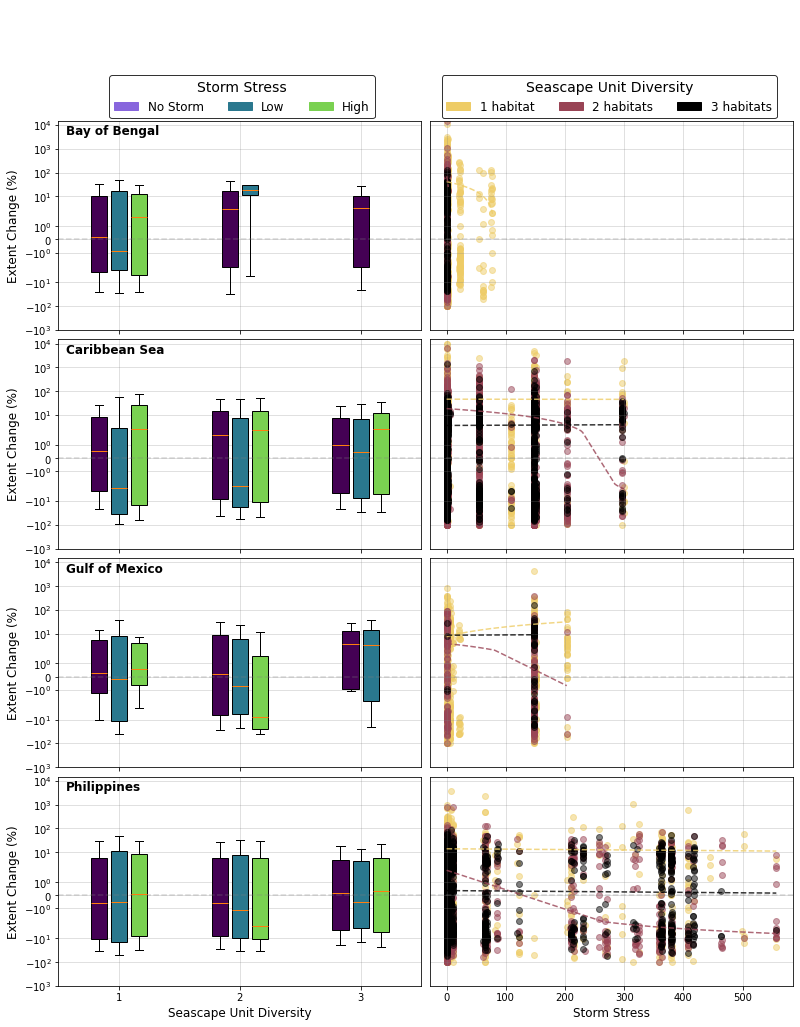

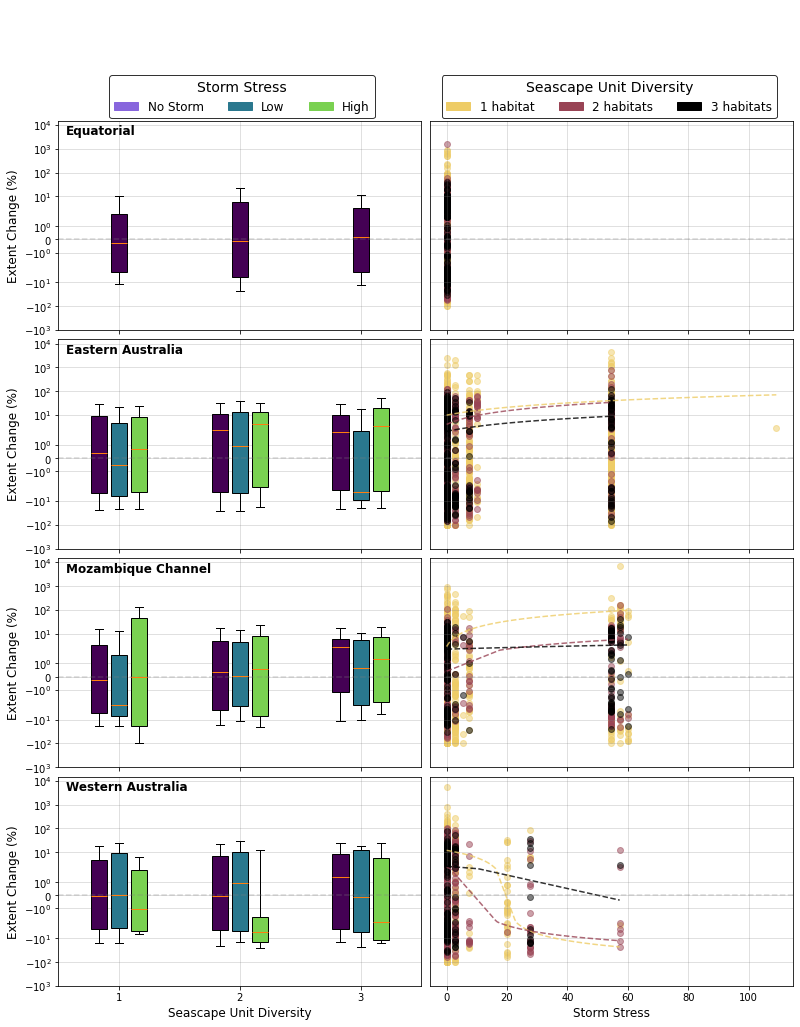

In [2]:
def get_full_region_name(region_code):
    """
    Convert region code to full region name, handling _v3 suffixes
    """
    # Remove _v3 suffix if present
    base_code = region_code.replace('_v3', '')
    
    region_names = {
        'GUF_MEX': 'Gulf of Mexico',
        'CAR_SEA': 'Caribbean Sea',
        'BAY_BEN': 'Bay of Bengal',
        'PHI_PIN': 'Philippines',
        'EQU_CON': 'Equatorial',
        'MOZ_MAD': 'Mozambique Channel',
        'EST_AUS': 'Eastern Australia',
        'WST_AUS': 'Western Australia'
    }
    return region_names.get(base_code, region_code)

def create_resilience_plots_by_region(df, regions, title, storm_impact_xlim=None):
    """
    Create figure with two plots per region, with shared axes
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the analysis data
    regions : list
        List of region codes to plot
    title : str
        Title for the figure
    storm_impact_xlim : tuple, optional
        (min, max) limits for storm impact x-axis. If None, auto-calculated.
    """
    # Import the formatter at the beginning of the function to avoid duplicate imports
    from matplotlib.ticker import LogFormatterSciNotation
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    n_regions = len(regions)
    fig = plt.figure(figsize=(12, 4*n_regions))  # Reduced width since we have 2 plots instead of 3
    fig.patch.set_facecolor('white')
    
    # Create GridSpec with 2 columns instead of 3
    gs = gridspec.GridSpec(n_regions + 1, 2, height_ratios=[0.5] + [1]*n_regions)
    gs.update(hspace=0.05, wspace=0.025)  # Minimal spacing between subplots
    
    # Create a single legend axis at the top with proper spacing for two separate horizontal legends
    legend_ax = fig.add_subplot(gs[0, :])
    legend_ax.axis('off')
    legend_ax.set_facecolor('white')
    
    # Create legend handles and labels
    # MODIFIED: Using only 3 storm categories now: No Storm, Low, High
    # storm_colors = [plt.cm.viridis(x) for x in [0.0, 0.4, 0.9]]  # Colors for No Storm, Low, High
    storm_colors = ['#8866DD', '#2A788E', '#7ad151'] ##440154
    storm_handles = [plt.Rectangle((0,0),1,1, color=c) for c in storm_colors]
    storm_labels = ['No Storm', 'Low', 'High']
    
    habitat_colors = ['#EECC66', '#994455', 'black'] ##590054
    habitat_handles = [plt.Rectangle((0,0),1,1, color=c) for c in habitat_colors]
    habitat_labels = ['1 habitat', '2 habitats', '3 habitats']
    
    # Create two separate horizontal legends - adjust positions for 2-column layout
    # Storm legend above the first column (position at 1/4 of the width)
    storm_legend = legend_ax.legend(storm_handles, storm_labels, 
                                    loc='upper center', 
                                    bbox_to_anchor=(0.25, 0.4),  # Adjusted for 2 columns
                                    ncol=3,  # All elements in one row
                                    title="Storm Stress", 
                                    title_fontsize=14, 
                                    fontsize=12,
                                    labelcolor='black',
                                    facecolor='white',
                                    edgecolor='black')
    
    # Add the storm legend to the axis (required when creating multiple legends)
    legend_ax.add_artist(storm_legend)
    
    # Habitat legend above the second column (position at 3/4 of the width)
    habitat_legend = legend_ax.legend(habitat_handles, habitat_labels, 
                                      loc='upper center',
                                      bbox_to_anchor=(0.75, 0.4),  # Adjusted for 2 columns 
                                      ncol=3,  # All elements in one row
                                      title="Seascape Unit Diversity", 
                                      title_fontsize=14, 
                                      fontsize=12,
                                      labelcolor='black',
                                      facecolor='white',
                                      edgecolor='black')
    
    # Create axes array - only 2 plots per row now (boxplot and storm pressure)
    axes = []
    for i in range(n_regions):
        row_axes = []
        for j in range(2):  # Only 2 columns now
            ax = fig.add_subplot(gs[i+1, j])
            ax.set_facecolor('white')
            
            # Share axes with first plot of each type, but handle EQU_CON separately
            region = regions[i]
            if region != 'EQU_CON':
                first_non_equ = next((idx for idx, r in enumerate(regions) if r != 'EQU_CON'), 0)
                if i > first_non_equ:
                    ax.sharex(axes[first_non_equ][j])
                if j > 0:
                    ax.sharey(row_axes[0])
            else:
                if j > 0:
                    ax.sharey(row_axes[0])
            
            row_axes.append(ax)
        axes.append(row_axes)
    
    # Get global y-limits for proper scaling
    all_losses = df['percent_change']
    y_min = min(all_losses.min(), -1000)  # Extend y-axis down to at least -10^3
    y_max = all_losses.max()
    
    # Create a formatter for all symlog axes to use scientific notation
    formatter = LogFormatterSciNotation(base=10)
    
    # # Define fixed colors for each category
    # # MODIFIED: Using only 3 storm categories now: No Storm, Low, High
    # storm_palette = {
    #     'No Storm': plt.cm.viridis(0.0),
    #     'Low': plt.cm.viridis(0.4),
    #     'High': plt.cm.viridis(0.9)
    # }
    
     # Define fixed colors for each category
    # MODIFIED: Using custom colors for storm categories
    storm_palette = {
        'No Storm': '#440154',  # Dark purple
        'Low': '#2A788E',       # Medium blue
        'High': '#7ad151'       # Light green
    }
    
    # Define spacing constants
    GROUP_SPACING = 1.5  # Increased spacing between habitat diversity groups
    WITHIN_GROUP_SPACING = 0.25  # Spacing between storm categories within a group
    
    for row, region in enumerate(regions):
        region_data = df[df['region'] == region].copy()
        
        # Skip if no data for this region
        if len(region_data) == 0:
            print(f"Warning: No data found for region {region}")
            for j in range(2):  # Only 2 plots now
                axes[row][j].text(0.5, 0.5, f'No Data for {region}', 
                                  ha='center', va='center', fontsize=12, color='black')
            continue
        
        # 1. Boxplot
        if region == 'EQU_CON':
            # Boxplot for EQU_CON with different habitat diversities
            boxplot_data = []
            positions = []
            
            # Get unique habitat diversities and sort them
            habitat_divs = sorted(region_data['habitat_diversity'].unique())
            
            # For each habitat diversity value
            for div_idx, div in enumerate(habitat_divs):
                div_data = region_data[region_data['habitat_diversity'] == div]
                
                # Extract data points
                data_points = div_data['percent_change']
                
                if len(data_points) > 0:
                    # Add data points to boxplot data
                    boxplot_data.append(data_points)
                    positions.append(div_idx * GROUP_SPACING + 1)
            
            # Create boxplot if we have data
            if boxplot_data:
                bplot = axes[row][0].boxplot(boxplot_data, positions=positions, patch_artist=True, 
                                             widths=0.6, showfliers=False)
                
                # Color all boxes lightblue since EQU_CON has no storm data
                for patch in bplot['boxes']:
                    patch.set_facecolor('lightblue')
                
                # Set x-ticks at habitat diversity positions
                axes[row][0].set_xticks([i * GROUP_SPACING + 1 for i in range(len(habitat_divs))])
                axes[row][0].set_xticklabels(habitat_divs)
            
            axes[row][0].set_yscale('symlog')
            axes[row][0].set_ylim(y_min, y_max)
            # Apply the consistent formatter here
            axes[row][0].yaxis.set_major_formatter(formatter)
        else:
            # Use matplotlib's boxplot directly to avoid seaborn's color issues
            # Group data by habitat diversity and storm exposure
            boxplot_data = []
            positions = []
            colors = []
            
            # Get unique habitat diversities and sort them
            habitat_divs = sorted(region_data['habitat_diversity'].unique())
            
            # For each habitat diversity value
            for div_idx, div in enumerate(habitat_divs):
                div_data = region_data[region_data['habitat_diversity'] == div]
                
                # Get unique storm exposures for this habitat diversity
                # MODIFIED: Now only looking for 'No Storm', 'Low', 'High'
                storm_exposures = sorted(div_data['storm_exposure'].unique(), 
                                         key=lambda x: ['No Storm', 'Low', 'High'].index(x))
                
                # For each storm exposure in this habitat diversity
                for exp_idx, exposure in enumerate(storm_exposures):
                    # Extract data points
                    data_points = div_data[div_data['storm_exposure'] == exposure]['percent_change']
                    
                    if len(data_points) > 0:
                        # Add data points to boxplot data
                        boxplot_data.append(data_points)
                        
                        base_position = div_idx * GROUP_SPACING + 1
                        position = base_position + exp_idx * WITHIN_GROUP_SPACING - (len(storm_exposures) - 1) * WITHIN_GROUP_SPACING / 2
                        positions.append(position)
                        
                        # Set color based on storm exposure
                        colors.append(storm_palette[exposure])
            
            # Create boxplot if we have data
            if boxplot_data:
                bplot = axes[row][0].boxplot(boxplot_data, positions=positions, patch_artist=True, 
                                             widths=0.2, showfliers=False)
                
                # Color each box according to its storm exposure
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set_facecolor(color)
                
                axes[row][0].set_xticks([i * GROUP_SPACING + 1 for i in range(len(habitat_divs))])
                axes[row][0].set_xticklabels(habitat_divs)
                
                # Set y-scale and limits
                axes[row][0].set_yscale('symlog')
                axes[row][0].set_ylim(y_min, y_max)
                # Apply the consistent formatter
                axes[row][0].yaxis.set_major_formatter(formatter)
        
        # 2. Storm impact plot or blank for EQU_CON (now this is the second plot)
        if region == 'EQU_CON':
            axes[row][1].text(0.5, 0.5, 'No Storm Data\nfor Equatorial Region', 
                              ha='center', va='center', fontsize=12, color='white')
            # Properly set y-tick labels for EQU_CON
            axes[row][1].set_yscale('symlog')
            axes[row][1].set_ylim(y_min, y_max)
            axes[row][1].yaxis.set_major_formatter(formatter)
        else:
            # MODIFIED: Using storm_pressure instead of storm_impact
            storm_pressure = region_data['storm_pressure']
            
            for i, div in enumerate(sorted(region_data['habitat_diversity'].unique())):
                mask = region_data['habitat_diversity'] == div
                subset_storm = storm_pressure[mask]
                subset_loss = region_data.loc[mask, 'percent_change']
                
                if len(subset_storm) > 0:
                    axes[row][1].scatter(subset_storm, subset_loss, 
                                         alpha=0.5, label=f'{div} habitat(s)',
                                         color=habitat_colors[i % len(habitat_colors)])
                
                    if len(subset_storm) > 2 and len(subset_storm.unique()) > 1:
                        try:
                            z = np.polyfit(subset_storm, subset_loss, 1)
                            p = np.poly1d(z)
                            x_range = np.linspace(subset_storm.min(), 
                                                 subset_storm.max(), 100)
                            axes[row][1].plot(x_range, p(x_range), '--', 
                                             color=habitat_colors[i % len(habitat_colors)], 
                                             alpha=0.8)
                        except Exception as e:
                            # Just skip the trendline if there's an error
                            print(f"Skipping trendline for {region}, habitat div {div}: {e}")
                            pass
            
            axes[row][1].set_yscale('symlog')
            axes[row][1].set_ylim(y_min, y_max)
            # Apply the consistent formatter
            axes[row][1].yaxis.set_major_formatter(formatter)
            
            # Handle x-axis limits for storm impact plots (added control)
            if storm_impact_xlim is not None:
                axes[row][1].set_xlim(storm_impact_xlim)
            elif region == 'WST_AUS':
                all_storm_pressures = df[df['region'] != 'EQU_CON']['storm_pressure']
                axes[row][1].set_xlim(-20.0, all_storm_pressures.max() * 0.1)
            
            if region == 'WST_AUS':
                axes[row][1].tick_params(axis='x', which='both', bottom=True, labelbottom=True)
            
            if axes[row][1].get_legend() is not None:
                axes[row][1].get_legend().remove()
        
        # Add zero reference lines and grid
        for ax in axes[row][:2 if region == 'EQU_CON' else 2]:
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
            ax.grid(True, alpha=0.3, color='gray')
        
        # Add region label inside the leftmost plot
        region_name = get_full_region_name(region)
        axes[row][0].text(0.02, 0.98, region_name, 
                          transform=axes[row][0].transAxes,
                          ha='left', va='top', fontsize=12, fontweight='bold', color='black')
        
        # Handle tick labels and axes
        for col in range(2):  # Only 2 columns now
            ax = axes[row][col]
            if row < len(regions) - 1:
                plt.setp(ax.get_xticklabels(), visible=False)
                ax.set_xlabel('')
            if col > 0:
                plt.setp(ax.get_yticklabels(), visible=False)
                ax.tick_params(axis='y', length=0)
                ax.set_ylabel('')
        
        # Set xlim for boxplots to make their scales consistent
        max_div_idx = len(habitat_divs) - 1
        x_max = max_div_idx * GROUP_SPACING + 1 + GROUP_SPACING/2
        x_min = 1 - GROUP_SPACING/2
        
        axes[row][0].set_xlim(x_min, x_max)
    
    # Set labels for bottom row
    axes[-1][0].set_xlabel('Seascape Unit Diversity', fontsize=12, color='black')
    axes[-1][1].set_xlabel('Storm Stress', fontsize=12, color='black')  # MODIFIED: Changed label to Storm Pressure
    
    # Set y-axis label for leftmost column
    for row in range(n_regions):
        axes[row][0].set_ylabel('Extent Change (%)', fontsize=12, color='black')
    
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)
    
    return fig

def main():
    # Read and prepare data
    import pandas as pd
    import numpy as np
    import math
    
    # Set dark theme globally
    # plt.style.use('dark_background')
    # plt.rcParams['text.color'] = 'white'
    # plt.rcParams['axes.labelcolor'] = 'white'
    # plt.rcParams['xtick.color'] = 'white'
    # plt.rcParams['ytick.color'] = 'white'
    # plt.rcParams['axes.edgecolor'] = 'white'
    
    df = pd.read_csv('all_regions_combined_v3.csv')
    
    # Calculate habitat diversity and extent changes
    df['habitat_diversity'] = (
        (df['mangrove_area_km2_2015'] > 0).astype(int) +
        (df['seagrass_area_km2_2015'] > 0).astype(int) +
        (df['reef_area_km2_2015'] > 0).astype(int)
    )
    
    df['total_extent_2015'] = (
        df['mangrove_area_km2_2015'] +
        df['seagrass_area_km2_2015'] +
        df['reef_area_km2_2015']
    )
    
    df['total_extent_2020'] = (
        df['mangrove_area_km2_2020'] +
        df['seagrass_area_km2_2020'] +
        df['reef_area_km2_2020']
    )
    
    # Calculate relative loss as (final-initial)/(initial)*100
    df['percent_change'] = ((df['total_extent_2020'] - df['total_extent_2015']) / df['total_extent_2015']) * 100
    
    # Remove outliers and zero extent
    df = df[df['total_extent_2015'] > 0].copy()
    
    # Remove outliers that are more than 3 standard deviations from the mean (added)
    loss_mean = df['percent_change'].mean()
    loss_std = df['percent_change'].std()
    df = df[abs(df['percent_change'] - loss_mean) <= 3 * loss_std].copy()
    
    # Process storm intensities
    def process_storm_intensities(intensities):
        if pd.isna(intensities) or intensities == 'none':
            return 0
        try:
            return np.mean([float(x) for x in str(intensities).split(', ')])
        except:
            return 0
    
    df['mean_storm_intensity'] = df['storm_intensities'].apply(process_storm_intensities)
    
    # MODIFIED: Calculate storm pressure using the new formula: Σ(exp(sshs))
    def calculate_storm_pressure(row):
        if pd.isna(row['storm_intensities']) or row['storm_intensities'] == 'none' or row['storm_count'] == 0:
            return 0

        try:
            intensities = [float(x) for x in str(row['storm_intensities']).split(', ')]
            return sum(np.exp(intensity) for intensity in intensities)
        except:
            return 0
    
#     # MODIFIED: Calculate storm pressure using the new formula: Σ(log10(sshs)+0.1)
#     def calculate_storm_pressure(row):
#         if pd.isna(row['storm_intensities']) or row['storm_intensities'] == 'none' or row['storm_count'] == 0:
#             return 0
        
#         try:
#             intensities = [float(x) for x in str(row['storm_intensities']).split(', ')]
#             return sum(np.log10(intensity + 0.1) for intensity in intensities)
#         except:
#             return 0
    
    df['storm_pressure'] = df.apply(calculate_storm_pressure, axis=1)
    
    # Initialize storm_exposure column with 'No Storm'
    df['storm_exposure'] = 'No Storm'
    
    # Store ranges for each region
    storm_ranges = {}
    
    # Handle storm exposure categories for non-EQU_CON regions
    # MODIFIED: Only using three categories now: No Storm, Low, High
    for region in df['region'].unique():
        if region != 'EQU_CON':
            region_mask = df['region'] == region
            storm_pressure = df.loc[region_mask, 'storm_pressure']
            
            # Get non-zero storm pressures
            non_zero_pressures = storm_pressure[storm_pressure > 0]
            
            if len(non_zero_pressures) > 0:
                # Calculate median to divide into Low and High
                median = np.median(non_zero_pressures)
                
                # Store ranges
                storm_ranges[region] = {
                    'No Storm': 0,
                    'Low': f"{non_zero_pressures.min():.2f}-{median:.2f}",
                    'High': f"{median:.2f}-{non_zero_pressures.max():.2f}"
                }
                
                # Assign categories
                df.loc[region_mask & (storm_pressure > 0) & (storm_pressure <= median), 'storm_exposure'] = 'Low'
                df.loc[region_mask & (storm_pressure > median), 'storm_exposure'] = 'High'
    
    # Print ranges for each region
    print("\nStorm Pressure Ranges by Region:")
    print("-" * 50)
    for region in sorted(storm_ranges.keys()):
        print(f"\n{region}:")
        for category, range_val in storm_ranges[region].items():
            print(f"  {category}: {range_val}")
    
    # Get the actual region names from the dataframe
    all_regions = df['region'].unique()
    
    # Separate into northern and southern regions
    northern_pattern = ['GUF_MEX', 'CAR_SEA', 'BAY_BEN', 'PHI_PIN']
    southern_pattern = ['EQU_CON', 'MOZ_MAD', 'EST_AUS', 'WST_AUS']
    
    # Match regions with the patterns
    northern_regions = [r for r in all_regions if any(pattern in r for pattern in northern_pattern)]
    southern_regions = [r for r in all_regions if any(pattern in r for pattern in southern_pattern)]
    
    # Sort to ensure consistent ordering
    northern_regions.sort()
    southern_regions.sort()
    
    # Set custom x-axis limits for storm impact plots
    storm_impact_xlim = None  # Auto-calculate based on new pressure values
    
    # Create plots with controlled x-axis limits
    fig_north = create_resilience_plots_by_region(df, northern_regions, 'Northern', storm_impact_xlim)
    fig_south = create_resilience_plots_by_region(df, southern_regions, 'Southern', storm_impact_xlim)
    
    # Save figures
    fig_north.savefig('northern_regions_resilience_plot_v5.jpg', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    fig_south.savefig('southern_regions_resilience_plot_v5.jpg', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
        # Save figures
    fig_north.savefig('northern_regions_resilience_plot_v5.svg', bbox_inches='tight', facecolor='white', edgecolor='none')
    fig_south.savefig('southern_regions_resilience_plot_v5.svg', bbox_inches='tight', facecolor='white', edgecolor='none')

    return df, fig_north, fig_south, storm_ranges

if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import seaborn as sns
    from numpy.linalg import LinAlgError
    import math
    
    df, fig_north, fig_south, storm_ranges = main()

### Regional stats code

Region mapping being used:
GUF_MEX → GUF_MEX_v3
CAR_SEA → CAR_SEA_v3
BAY_BEN → BAY_BEN_v3
PHI_PIN → PHI_PIN_v3
EQU_CON → EQU_CON_v3
MOZ_MAD → MOZ_MAD_v3
EST_AUS → EST_AUS_v3
WST_AUS → WST_AUS_v3
GLOBAL ANALYSIS: HABITAT DIVERSITY AND RESILIENCE

Normality Test Results for percent_change by habitat_diversity:
------------------------------------------------------------
Group 2 (n=5105): D'Agostino-Pearson test p=0.0000 - Non-normal distribution
Group 1 (n=8851): D'Agostino-Pearson test p=0.0000 - Non-normal distribution
Group 3 (n=3412): Shapiro-Wilk test p=0.0000 - Non-normal distribution

Overall percent_change (n=17368): D'Agostino-Pearson test p=0.0000 - Non-normal distribution
Q-Q plot saved as qq_plot_percent_change.png
Histogram saved as histogram_percent_change.png

Test recommendation based on normality: Non-parametric tests (Mann-Whitney U, Kruskal-Wallis, Spearman correlation)
Global Spearman correlation between habitat diversity and extent change: r = 0.019, p = 0.0144
Krusk

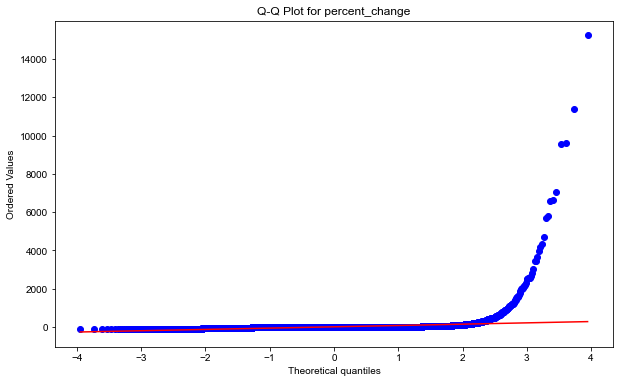

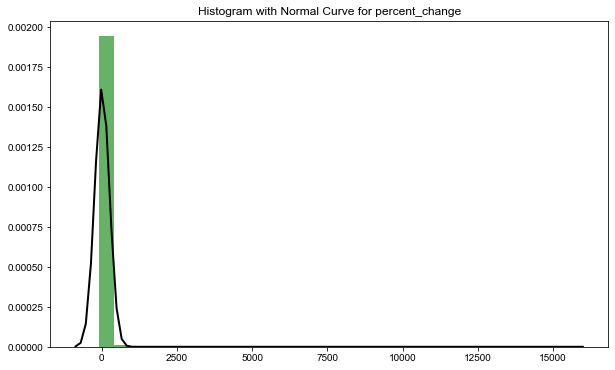

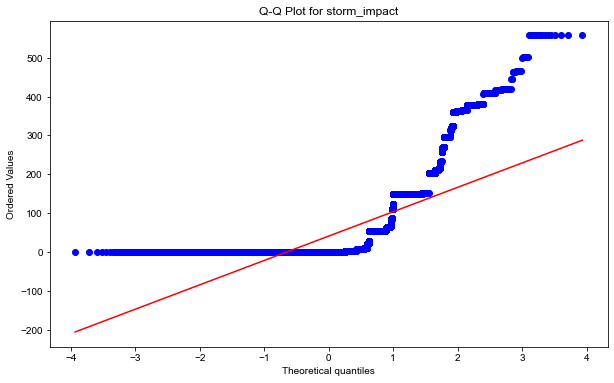

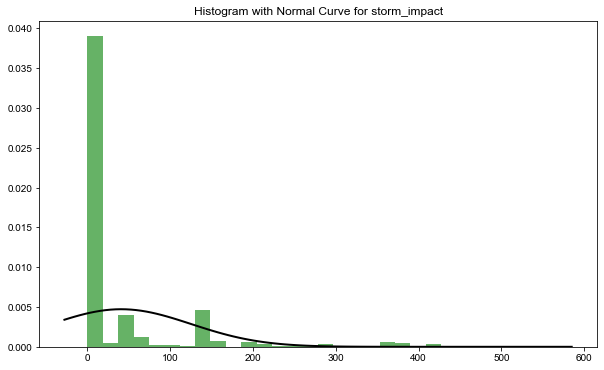

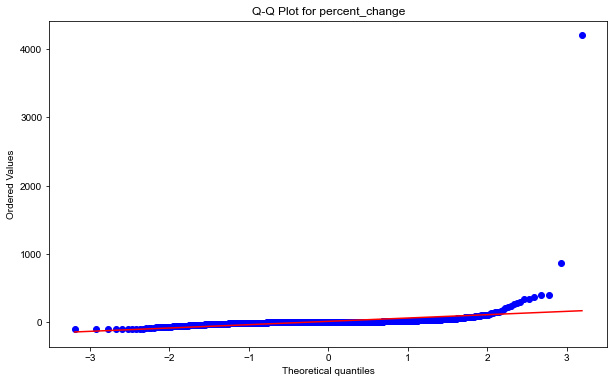

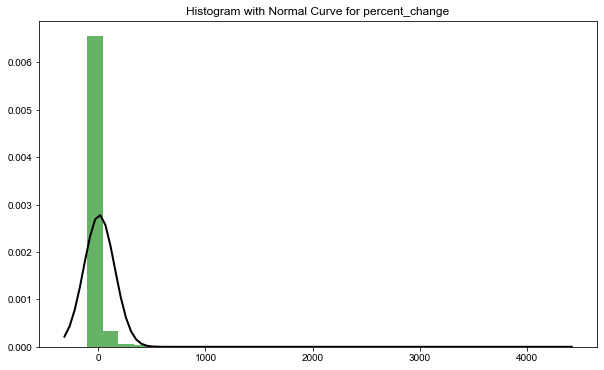

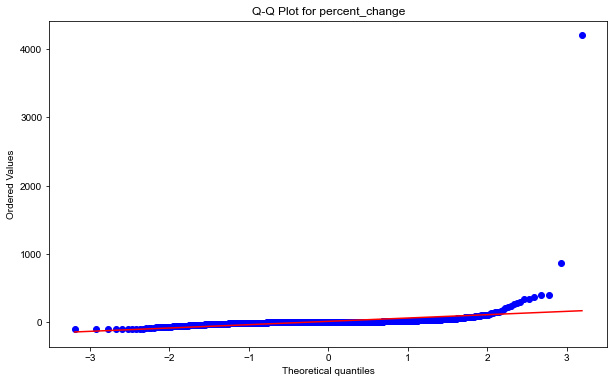

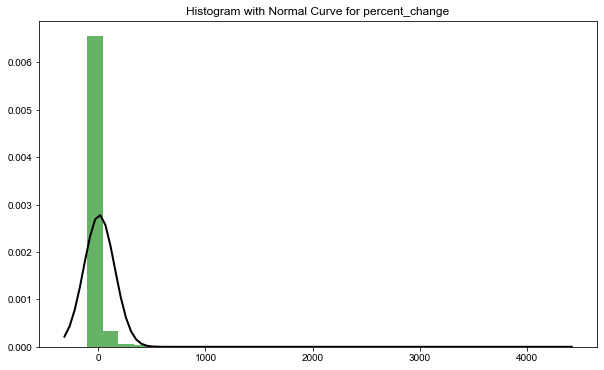

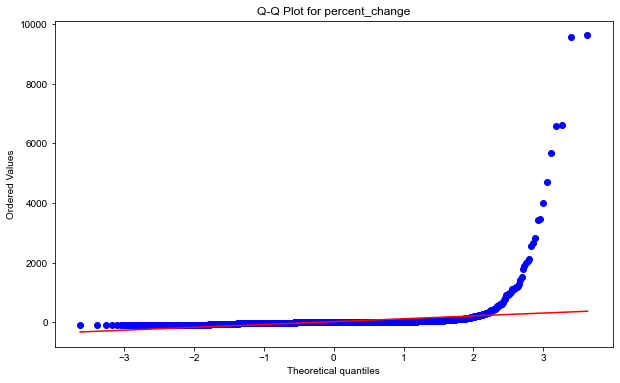

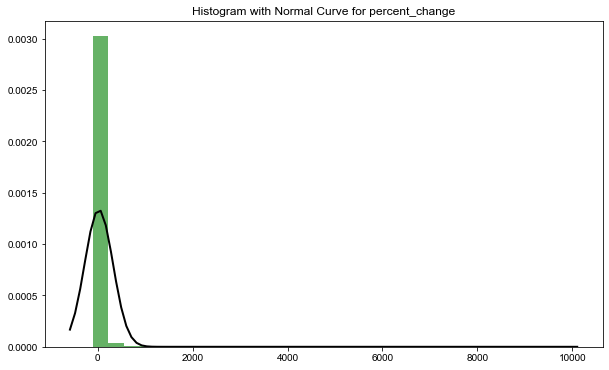

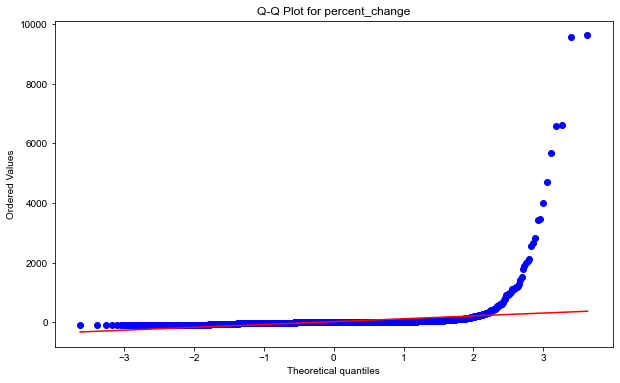

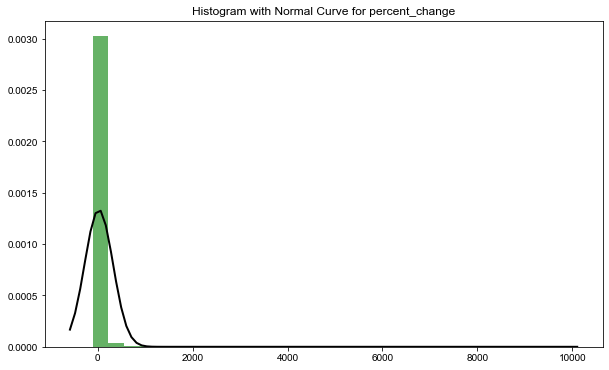

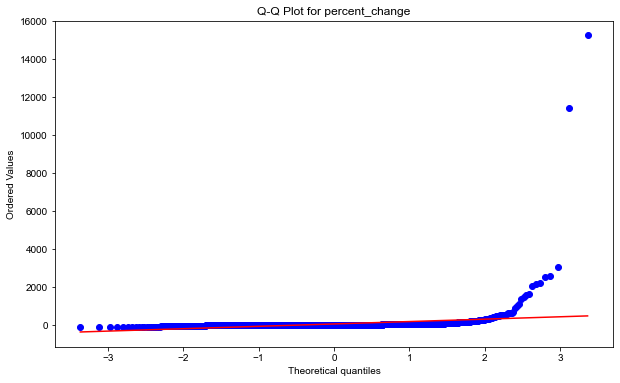

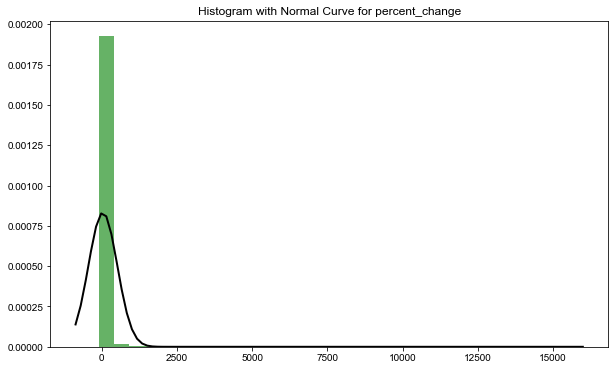

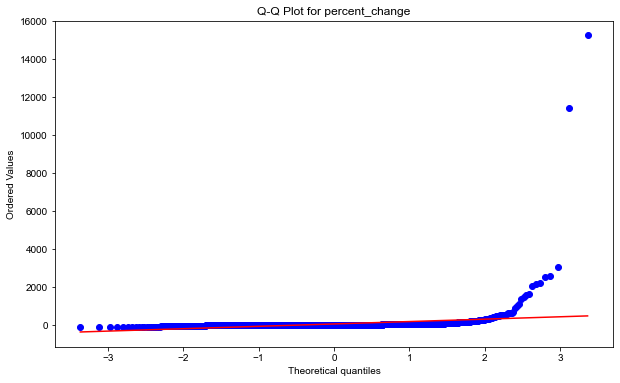

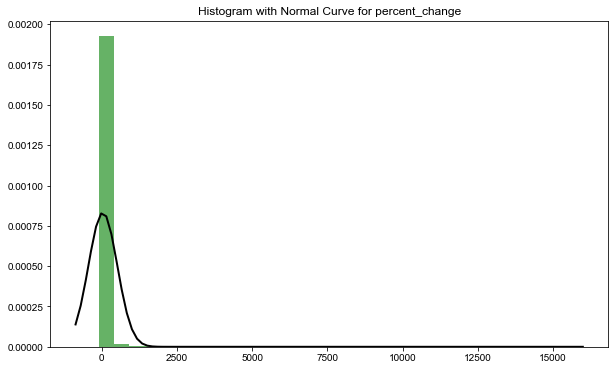

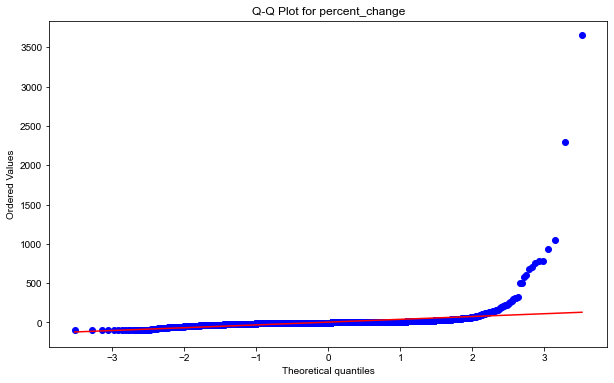

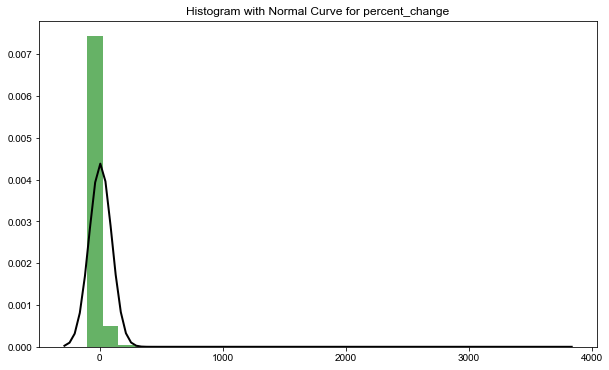

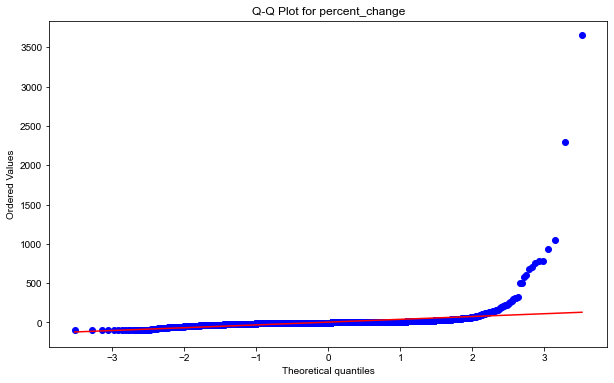

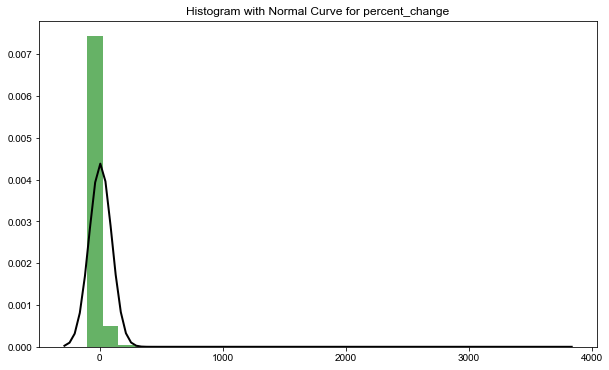

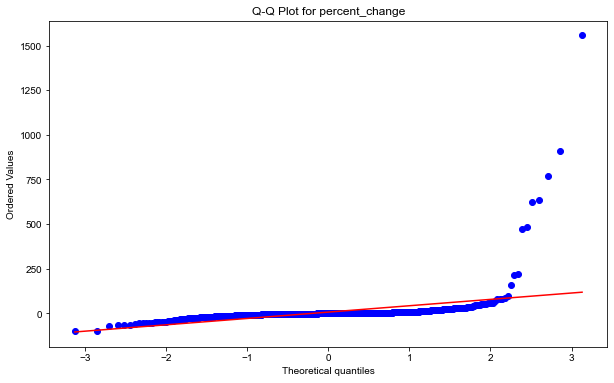

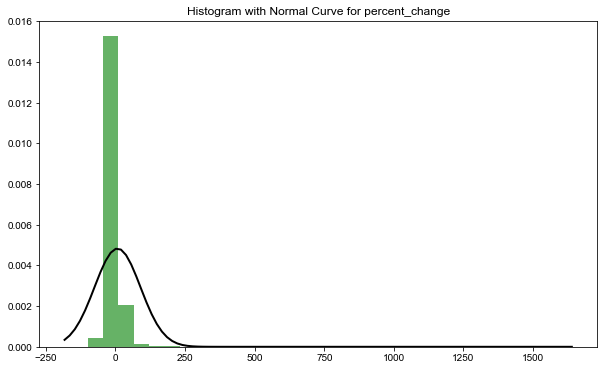

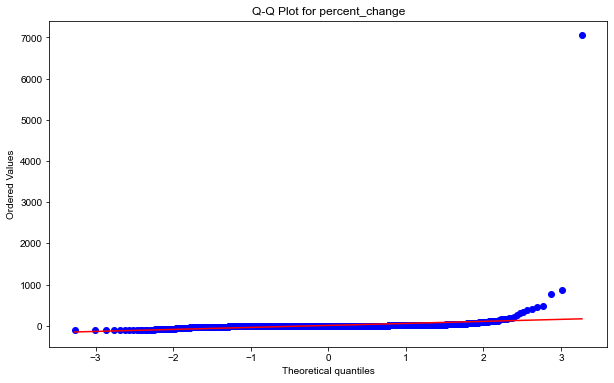

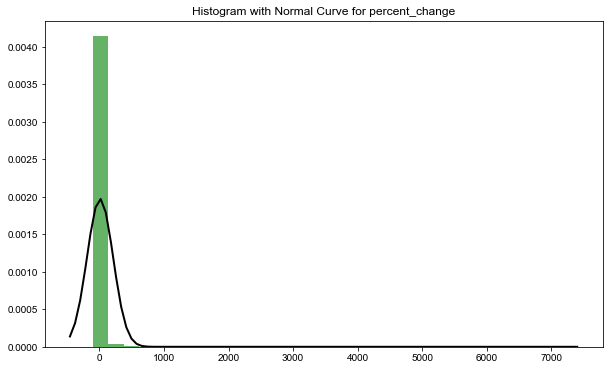

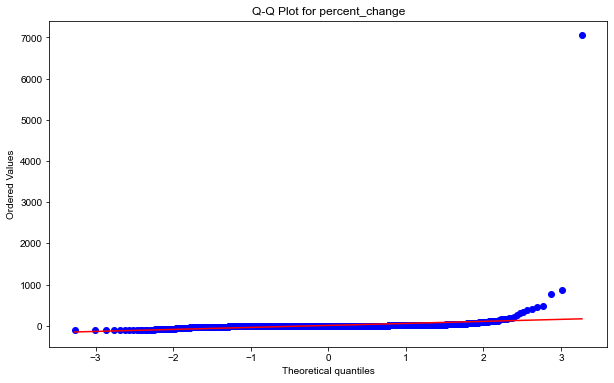

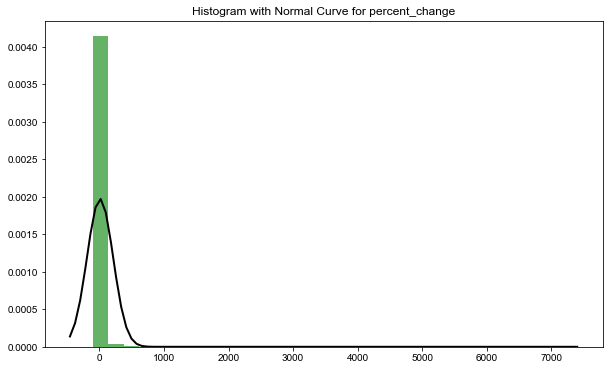

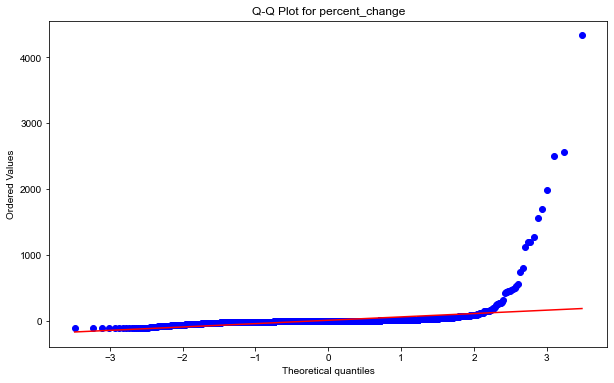

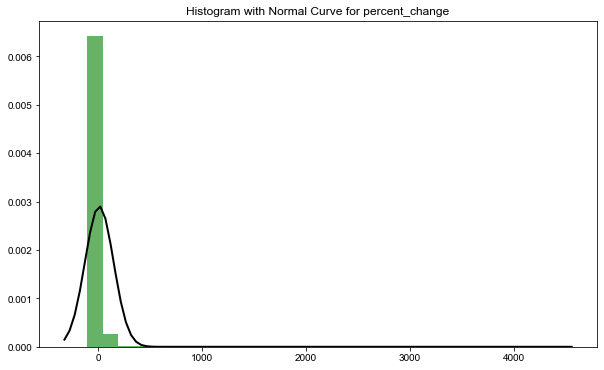

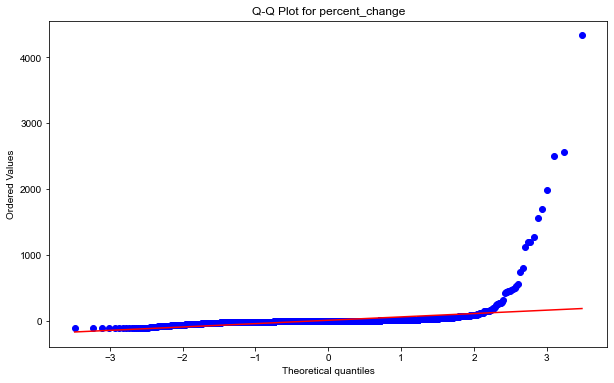

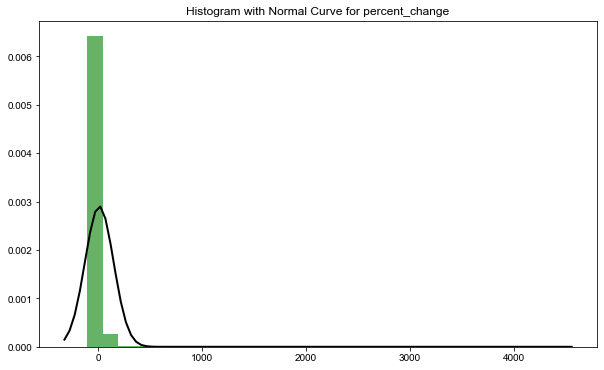

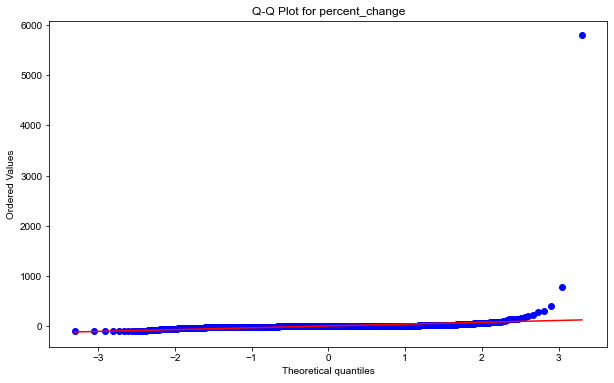

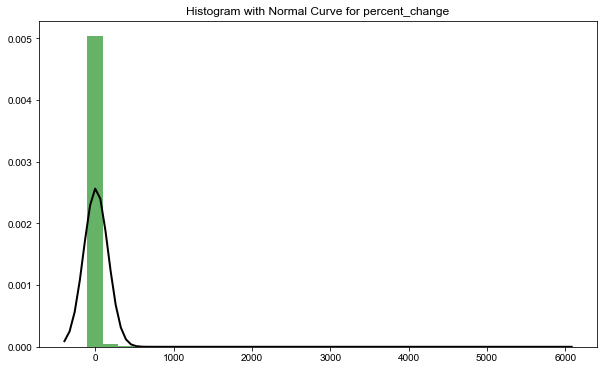

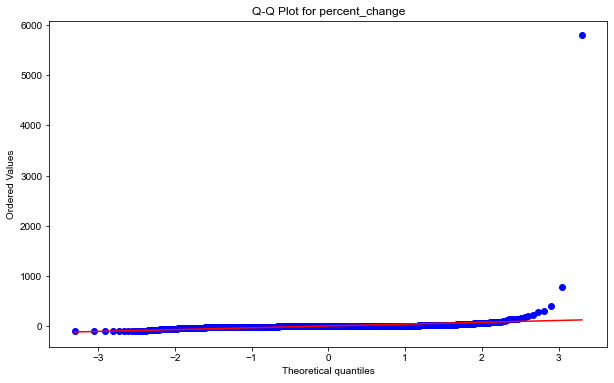

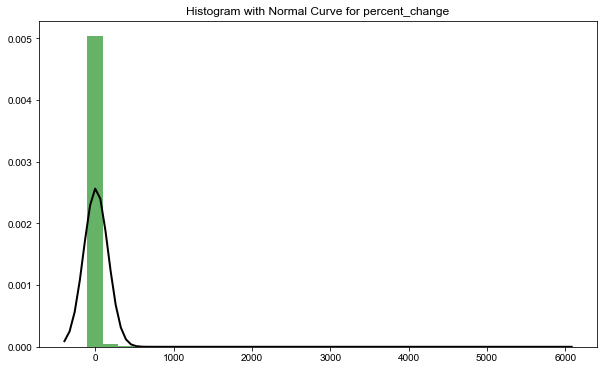

In [18]:
def check_normality(data, group_column, value_column, alpha=0.05):
    """
    Test for normality within groups and return appropriate test recommendation
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataframe
    group_column : str
        Column name containing the grouping variable
    value_column : str
        Column name containing the values to test
    alpha : float
        Significance level for normality tests
    
    Returns:
    --------
    is_normal : bool
        Whether the data appears normally distributed
    test_recommendation : str
        Recommended test based on normality results
    """
    from scipy.stats import shapiro, normaltest
    import numpy as np
    
    groups = data[group_column].unique()
    results = {}
    
    print(f"\nNormality Test Results for {value_column} by {group_column}:")
    print("-" * 60)
    
    all_normal = True
    
    for group in groups:
        group_data = data[data[group_column] == group][value_column].dropna()
        
        # Skip if too few samples
        if len(group_data) < 8:
            print(f"Group {group}: Too few samples ({len(group_data)}) for reliable normality test")
            results[group] = "Unknown (too few samples)"
            continue
            
        # Shapiro-Wilk test (better for smaller samples)
        if len(group_data) < 5000:
            stat, p = shapiro(group_data)
            test_name = "Shapiro-Wilk"
        else:
            # D'Agostino's K^2 test for larger samples
            stat, p = normaltest(group_data)
            test_name = "D'Agostino-Pearson"
        
        is_normal = p > alpha
        results[group] = is_normal
        
        if not is_normal:
            all_normal = False
        
        print(f"Group {group} (n={len(group_data)}): {test_name} test p={p:.4f} - {'Normal' if is_normal else 'Non-normal'} distribution")
    
    # Check overall normality for the entire dataset
    all_data = data[value_column].dropna()
    if len(all_data) < 5000:
        stat, p = shapiro(all_data)
        test_name = "Shapiro-Wilk"
    else:
        stat, p = normaltest(all_data)
        test_name = "D'Agostino-Pearson"
    
    overall_normal = p > alpha
    print(f"\nOverall {value_column} (n={len(all_data)}): {test_name} test p={p:.4f} - {'Normal' if overall_normal else 'Non-normal'} distribution")
    
    # Visual check with QQ plot
    try:
        import matplotlib.pyplot as plt
        from scipy import stats
        
        plt.figure(figsize=(10, 6))
        
        # Create Q-Q plot
        stats.probplot(all_data, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot for {value_column}")
        plt.savefig(f"qq_plot_{value_column}.png")
        print(f"Q-Q plot saved as qq_plot_{value_column}.png")
        
        # Create histogram with normal curve
        plt.figure(figsize=(10, 6))
        plt.hist(all_data, bins=30, density=True, alpha=0.6, color='g')
        
        # Plot normal distribution curve
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, all_data.mean(), all_data.std())
        plt.plot(x, p, 'k', linewidth=2)
        
        plt.title(f"Histogram with Normal Curve for {value_column}")
        plt.savefig(f"histogram_{value_column}.png")
        print(f"Histogram saved as histogram_{value_column}.png")
    except Exception as e:
        print(f"Could not create normality visualization: {str(e)}")
    
    # Determine test recommendation
    if all_normal and overall_normal:
        test_recommendation = "Parametric tests (t-test, ANOVA, Pearson correlation)"
    else:
        test_recommendation = "Non-parametric tests (Mann-Whitney U, Kruskal-Wallis, Spearman correlation)"
    
    print(f"\nTest recommendation based on normality: {test_recommendation}")
    
    return all_normal and overall_normal, test_recommendation

def analyze_resilience(df):
    """
    Analyze habitat diversity and resilience across regions with appropriate statistical tests
    """
    results = {}
    
    # Get the base region codes we're looking for
    base_regions = ['GUF_MEX', 'CAR_SEA', 'BAY_BEN', 'PHI_PIN', 'EQU_CON', 'MOZ_MAD', 'EST_AUS', 'WST_AUS']
    
    # Create a mapping from base codes to actual region names in the data
    actual_regions = df['region'].unique()
    region_mapping = {}
    for base_region in base_regions:
        for actual_region in actual_regions:
            if base_region in actual_region:
                region_mapping[base_region] = actual_region
                break
    
    # Print the mapping for verification
    print("Region mapping being used:")
    for base, actual in region_mapping.items():
        print(f"{base} → {actual}")
    
    # Define regions using the mapping
    northern_regions = ['GUF_MEX', 'CAR_SEA', 'BAY_BEN', 'PHI_PIN']
    southern_regions = ['EQU_CON', 'MOZ_MAD', 'EST_AUS', 'WST_AUS']
    all_regions = northern_regions + southern_regions
    
    # Print global analysis first
    print("="*80)
    print("GLOBAL ANALYSIS: HABITAT DIVERSITY AND RESILIENCE")
    print("="*80)
    
    # Check normality of percent change data
    is_normal, test_recommendation = check_normality(df, 'habitat_diversity', 'percent_change')
    
    # Global correlation between habitat diversity and percent change
    # Spearman is always appropriate (works for both normal and non-normal data)
    from scipy.stats import spearmanr, pearsonr
    global_spearman, global_spearman_p = spearmanr(df['habitat_diversity'], df['percent_change'])
    print(f"Global Spearman correlation between habitat diversity and extent change: r = {global_spearman:.3f}, p = {global_spearman_p:.4f}")
    
    # Add Pearson correlation if data is normally distributed
    if is_normal:
        global_pearson, global_pearson_p = pearsonr(df['habitat_diversity'], df['percent_change'])
        print(f"Global Pearson correlation between habitat diversity and extent change: r = {global_pearson:.3f}, p = {global_pearson_p:.4f}")
    
    # Test difference in resilience across habitat diversity levels
    from scipy.stats import f_oneway, kruskal
    groups = [df[df['habitat_diversity'] == i]['percent_change'] for i in sorted(df['habitat_diversity'].unique())]
    
    # Run the appropriate test based on normality
    if is_normal:
        # ANOVA if normal
        f_stat, anova_p = f_oneway(*groups)
        print(f"ANOVA test for differences in extent change across habitat diversity levels: F = {f_stat:.3f}, p = {anova_p:.4f}")
        test_result = anova_p
        test_name = "ANOVA"
    else:
        # Kruskal-Wallis if non-normal
        h_stat, kw_p = kruskal(*groups)
        print(f"Kruskal-Wallis test for differences in extent change across habitat diversity levels: H = {h_stat:.3f}, p = {kw_p:.4f}")
        test_result = kw_p
        test_name = "Kruskal-Wallis"
    
    # Calculate mean percent change by habitat diversity
    diversity_means = df.groupby('habitat_diversity')['percent_change'].agg(['mean', 'median', 'std', 'count'])
    print("\nGlobal Extent Change by Habitat Diversity:")
    for idx, row in diversity_means.iterrows():
        print(f"Habitat Diversity {idx}: Mean = {row['mean']:.2f}%, Median = {row['median']:.2f}%, Std = {row['std']:.2f}%, n = {row['count']}")
    
    # Post-hoc tests if main test is significant
    if test_result < 0.05:
        if is_normal:
            # Tukey's HSD post-hoc for normal data with ANOVA
            from statsmodels.stats.multicomp import pairwise_tukeyhsd
            tukey = pairwise_tukeyhsd(df['percent_change'], df['habitat_diversity'])
            print("\nTukey's HSD Post-hoc Test Results:")
            print(tukey)
        else:
            # Dunn's test for non-normal data with Kruskal-Wallis
            try:
                from scikit_posthocs import posthoc_dunn
                import pandas as pd
                # Create a dataframe for Dunn's test
                dunn_df = pd.DataFrame()
                for i, group in enumerate(sorted(df['habitat_diversity'].unique())):
                    dunn_df[f'Group_{group}'] = pd.Series(df[df['habitat_diversity'] == group]['percent_change'].values)
                
                # Run Dunn's test
                dunn_result = posthoc_dunn(dunn_df, p_adjust='bonferroni')
                print("\nDunn's Post-hoc Test Results (p-values):")
                print(dunn_result)
            except ImportError:
                print("\nCould not run Dunn's post-hoc test. Consider installing scikit-posthocs for non-parametric post-hoc tests.")
                # Manual pairwise Mann-Whitney as fallback
                from scipy.stats import mannwhitneyu
                from itertools import combinations
                
                print("\nPairwise Mann-Whitney U Tests (with Bonferroni correction):")
                diversity_levels = sorted(df['habitat_diversity'].unique())
                n_tests = len(list(combinations(diversity_levels, 2)))
                alpha_corrected = 0.05 / n_tests  # Bonferroni correction
                
                for a, b in combinations(diversity_levels, 2):
                    group_a = df[df['habitat_diversity'] == a]['percent_change']
                    group_b = df[df['habitat_diversity'] == b]['percent_change']
                    u_stat, p_value = mannwhitneyu(group_a, group_b, alternative='two-sided')
                    significance = "Significant" if p_value < alpha_corrected else "Not significant"
                    print(f"Diversity {a} vs {b}: U = {u_stat}, p = {p_value:.4f}, {significance} (Bonferroni-corrected α = {alpha_corrected:.4f})")
    
    # Storm Impact Analysis at global level
    print("\n" + "="*80)
    print("GLOBAL STORM IMPACT ANALYSIS")
    print("="*80)
    
    # For all non-equatorial regions (which have storm data)
    non_eq_mask = ~df['region'].str.contains('EQU_CON')
    non_eq_df = df[non_eq_mask]
    
    # Calculate storm impact 
    non_eq_df['storm_impact'] = non_eq_df['storm_pressure']  # Using storm_pressure directly
    
    # Check normality for storm impact data
    storm_is_normal, storm_test_rec = check_normality(non_eq_df, 'habitat_diversity', 'storm_impact')
    
    # Analyze correlation between storm impact and percent change
    storm_spearman, storm_spearman_p = spearmanr(non_eq_df['storm_impact'], non_eq_df['percent_change'])
    print(f"Global Spearman correlation between storm impact and extent change: r = {storm_spearman:.3f}, p = {storm_spearman_p:.4f}")
    
    if storm_is_normal:
        storm_pearson, storm_pearson_p = pearsonr(non_eq_df['storm_impact'], non_eq_df['percent_change'])
        print(f"Global Pearson correlation between storm impact and extent change: r = {storm_pearson:.3f}, p = {storm_pearson_p:.4f}")
    
    # Analyze if high diversity mitigates storm impact - interaction effect
    # For this, we'll compare correlations within each diversity level
    for div in sorted(non_eq_df['habitat_diversity'].unique()):
        div_df = non_eq_df[non_eq_df['habitat_diversity'] == div]
        if len(div_df) > 5:  # Ensure enough data points
            div_corr, div_p = spearmanr(div_df['storm_impact'], div_df['percent_change'])
            print(f"Diversity {div}: Storm impact vs. extent change correlation: r = {div_corr:.3f}, p = {div_p:.4f}, n = {len(div_df)}")
    
    # Linear model comparing slopes for diversity levels (simplified approach)
    try:
        from statsmodels.formula.api import ols
        import statsmodels.api as sm
        
        # Create interaction term with OLS model
        formula = 'percent_change ~ storm_impact * habitat_diversity'
        model = ols(formula, data=non_eq_df).fit()
        
        print("\nLinear Model Results (Extent Change ~ Storm Impact * Habitat Diversity):")
        print(f"R-squared: {model.rsquared:.3f}")
        print(f"Interaction p-value: {model.pvalues['storm_impact:habitat_diversity']:.4f}")
        print(f"Interaction term significant?: {'Yes' if model.pvalues['storm_impact:habitat_diversity'] < 0.05 else 'No'}")
        
        # Additional robust regression for non-normal data
        if not is_normal:
            try:
                from statsmodels.formula.api import rlm
                robust_model = rlm(formula=formula, data=non_eq_df).fit()
                print("\nRobust Regression Results (more appropriate for non-normal data):")
                print(f"Converged: {robust_model.converged}")
                for param in robust_model.params.index:
                    print(f"{param}: {robust_model.params[param]:.4f}, p = {robust_model.pvalues[param] if hasattr(robust_model, 'pvalues') else 'N/A'}")
            except Exception as e:
                print(f"Could not run robust regression: {str(e)}")
    except Exception as e:
        print(f"Could not run linear model analysis: {str(e)}")
    
    # Mean and median by storm exposure category
    print("\nGlobal Extent Change by Storm Exposure Category:")
    storm_exposure_stats = non_eq_df.groupby('storm_exposure')['percent_change'].agg(['mean', 'median', 'std', 'count'])
    for idx, row in storm_exposure_stats.iterrows():
        print(f"{idx}: Mean = {row['mean']:.2f}%, Median = {row['median']:.2f}%, Std = {row['std']:.2f}%, n = {row['count']}")
    
    # Test for differences between storm exposure categories
    storm_groups = [non_eq_df[non_eq_df['storm_exposure'] == cat]['percent_change'] 
                   for cat in sorted(non_eq_df['storm_exposure'].unique())]
    
    # Run appropriate test based on normality
    if is_normal:
        storm_f, storm_anova_p = f_oneway(*storm_groups)
        print(f"\nANOVA test for differences across storm exposure categories: F = {storm_f:.3f}, p = {storm_anova_p:.4f}")
        if storm_anova_p < 0.05:
            storm_tukey = pairwise_tukeyhsd(non_eq_df['percent_change'], non_eq_df['storm_exposure'])
            print("\nTukey's HSD Post-hoc Test for Storm Categories:")
            print(storm_tukey)
    else:
        storm_h, storm_kw_p = kruskal(*storm_groups)
        print(f"\nKruskal-Wallis test for differences across storm exposure categories: H = {storm_h:.3f}, p = {storm_kw_p:.4f}")
        if storm_kw_p < 0.05:
            try:
                # Dunn's test for non-parametric post-hoc
                from scikit_posthocs import posthoc_dunn
                storm_dunn_df = pd.DataFrame()
                for i, group in enumerate(sorted(non_eq_df['storm_exposure'].unique())):
                    storm_dunn_df[f'Group_{group}'] = pd.Series(non_eq_df[non_eq_df['storm_exposure'] == group]['percent_change'].values)
                
                storm_dunn_result = posthoc_dunn(storm_dunn_df, p_adjust='bonferroni')
                print("\nDunn's Post-hoc Test for Storm Categories (p-values):")
                print(storm_dunn_result)
            except ImportError:
                print("\nCould not run Dunn's post-hoc test for storm categories.")
                # Manual pairwise Mann-Whitney as fallback
                from scipy.stats import mannwhitneyu
                from itertools import combinations
                
                print("\nPairwise Mann-Whitney U Tests for Storm Categories (with Bonferroni correction):")
                storm_cats = sorted(non_eq_df['storm_exposure'].unique())
                n_tests = len(list(combinations(storm_cats, 2)))
                alpha_corrected = 0.05 / n_tests  # Bonferroni correction
                
                for a, b in combinations(storm_cats, 2):
                    group_a = non_eq_df[non_eq_df['storm_exposure'] == a]['percent_change']
                    group_b = non_eq_df[non_eq_df['storm_exposure'] == b]['percent_change']
                    u_stat, p_value = mannwhitneyu(group_a, group_b, alternative='two-sided')
                    significance = "Significant" if p_value < alpha_corrected else "Not significant"
                    print(f"{a} vs {b}: U = {u_stat}, p = {p_value:.4f}, {significance} (Bonferroni-corrected α = {alpha_corrected:.4f})")
    
    # Regional Analyses
    print("\n" + "="*80)
    print("REGIONAL ANALYSES")
    print("="*80)
    
    def analyze_region(region_data, region_name, base_region=None):
        """
        Analyze a single region with appropriate statistical tests
        """
        import pandas as pd  # Add this import at the beginning of the function
        from scipy.stats import spearmanr, pearsonr, f_oneway, kruskal

        results = {}
        display_name = base_region if base_region else region_name
        full_name = get_full_region_name(display_name)
        print(f"\nRegion: {full_name} ({region_name})")
        print("-" * 50)
        
        # Count samples and diversity levels
        results['n_samples'] = len(region_data)
        results['diversity_levels'] = sorted(region_data['habitat_diversity'].unique())
        print(f"Number of samples: {results['n_samples']}")
        print(f"Habitat diversity levels present: {results['diversity_levels']}")
        
        # Skip further analysis if insufficient data
        if len(region_data) < 5:
            print("Insufficient data for detailed analysis")
            return results
        
        # Check normality for this region
        regional_normal, regional_test_rec = check_normality(region_data, 'habitat_diversity', 'percent_change', alpha=0.01)
        
        # Correlation between habitat diversity and percent change
        div_spearman, div_spearman_p = spearmanr(region_data['habitat_diversity'], region_data['percent_change'])
        results['div_correlation'] = div_spearman
        results['div_p_value'] = div_spearman_p
        print(f"Spearman correlation between habitat diversity and extent change: r = {div_spearman:.3f}, p = {div_spearman_p:.4f}")
        
        if regional_normal:
            div_pearson, div_pearson_p = pearsonr(region_data['habitat_diversity'], region_data['percent_change'])
            results['div_pearson'] = div_pearson
            results['div_pearson_p'] = div_pearson_p
            print(f"Pearson correlation between habitat diversity and extent change: r = {div_pearson:.3f}, p = {div_pearson_p:.4f}")
        
        # Mean extent change by habitat diversity
        regional_div_means = region_data.groupby('habitat_diversity')['percent_change'].agg(['mean', 'median', 'std', 'count'])
        print("\nExtent Change by Habitat Diversity:")
        for idx, row in regional_div_means.iterrows():
            print(f"Diversity {idx}: Mean = {row['mean']:.2f}%, Median = {row['median']:.2f}%, Std = {row['std']:.2f}%, n = {row['count']}")
        
        # Statistical test if more than one diversity level
        if len(region_data['habitat_diversity'].unique()) > 1:
            regional_groups = [region_data[region_data['habitat_diversity'] == i]['percent_change'] 
                              for i in sorted(region_data['habitat_diversity'].unique())]
            try:
                if regional_normal:
                    # ANOVA for normal data
                    regional_f, regional_p = f_oneway(*regional_groups)
                    results['anova_f'] = regional_f
                    results['anova_p'] = regional_p
                    print(f"\nANOVA: F = {regional_f:.3f}, p = {regional_p:.4f}")
                    
                    # Post-hoc if significant
                    if regional_p < 0.05 and len(regional_groups) > 2:
                        from statsmodels.stats.multicomp import pairwise_tukeyhsd
                        regional_tukey = pairwise_tukeyhsd(region_data['percent_change'], region_data['habitat_diversity'])
                        print("\nTukey's HSD Post-hoc Test Results:")
                        print(regional_tukey)
                else:
                    # Kruskal-Wallis for non-normal data
                    regional_h, regional_p = kruskal(*regional_groups)
                    results['kw_h'] = regional_h
                    results['kw_p'] = regional_p
                    print(f"\nKruskal-Wallis: H = {regional_h:.3f}, p = {regional_p:.4f}")
                    
                    # Post-hoc if significant
                    if regional_p < 0.05 and len(regional_groups) > 2:
                        try:
                            from scikit_posthocs import posthoc_dunn
                            regional_dunn_df = pd.DataFrame()
                            for i, group in enumerate(sorted(region_data['habitat_diversity'].unique())):
                                regional_dunn_df[f'Group_{group}'] = pd.Series(region_data[region_data['habitat_diversity'] == group]['percent_change'].values)
                            
                            regional_dunn_result = posthoc_dunn(regional_dunn_df, p_adjust='bonferroni')
                            print("\nDunn's Post-hoc Test Results (p-values):")
                            print(regional_dunn_result)
                        except ImportError:
                            print("\nCould not run Dunn's post-hoc test.")
            except Exception as e:
                print(f"Could not perform statistical test: {str(e)}")
        
        # Storm analysis if not equatorial region
        if 'EQU_CON' not in region_name:
            print("\nStorm Impact Analysis:")
            
            # Calculate storm impact using storm pressure
            region_data['storm_impact'] = region_data['storm_pressure'] 
            
            # Check normality for storm data
            storm_regional_normal, _ = check_normality(region_data, 'storm_exposure', 'percent_change', alpha=0.01)
            
            # Correlation between storm impact and percent change
            reg_storm_spearman, reg_storm_spearman_p = spearmanr(region_data['storm_impact'], region_data['percent_change'])
            results['storm_correlation'] = reg_storm_spearman
            results['storm_p_value'] = reg_storm_spearman_p
            print(f"Spearman correlation between storm impact and extent change: r = {reg_storm_spearman:.3f}, p = {reg_storm_spearman_p:.4f}")
            
            if storm_regional_normal:
                reg_storm_pearson, reg_storm_pearson_p = pearsonr(region_data['storm_impact'], region_data['percent_change'])
                results['storm_pearson'] = reg_storm_pearson
                results['storm_pearson_p'] = reg_storm_pearson_p
                print(f"Pearson correlation between storm impact and extent change: r = {reg_storm_pearson:.3f}, p = {reg_storm_pearson_p:.4f}")
            
            # Mean extent change by storm exposure
            region_storm_means = region_data.groupby('storm_exposure')['percent_change'].agg(['mean', 'median', 'std', 'count'])
            print("\nExtent Change by Storm Exposure:")
            for idx, row in region_storm_means.iterrows():
                if not pd.isna(row['mean']):  # Skip if NaN
                    print(f"{idx}: Mean = {row['mean']:.2f}%, Median = {row['median']:.2f}%, Std = {row['std']:.2f}%, n = {row['count']}")
            
            # Statistical test for differences between storm categories if we have multiple categories
            if len(region_data['storm_exposure'].unique()) > 1:
                regional_storm_groups = [region_data[region_data['storm_exposure'] == cat]['percent_change'] 
                                        for cat in sorted(region_data['storm_exposure'].unique())]
                
                try:
                    if storm_regional_normal:
                        reg_storm_f, reg_storm_p = f_oneway(*regional_storm_groups)
                        print(f"\nANOVA for storm categories: F = {reg_storm_f:.3f}, p = {reg_storm_p:.4f}")
                    else:
                        reg_storm_h, reg_storm_p = kruskal(*regional_storm_groups)
                        print(f"\nKruskal-Wallis for storm categories: H = {reg_storm_h:.3f}, p = {reg_storm_p:.4f}")
                except Exception as e:
                    print(f"Could not perform statistical test for storm categories: {str(e)}")
            
            # Look at storm impact by diversity level
            print("\nStorm Impact Correlation by Diversity Level:")
            for div in sorted(region_data['habitat_diversity'].unique()):
                div_data = region_data[region_data['habitat_diversity'] == div]
                if len(div_data) > 5:  # Ensure enough data
                    div_storm_corr, div_storm_p = spearmanr(div_data['storm_impact'], div_data['percent_change'])
                    print(f"Diversity {div}: r = {div_storm_corr:.3f}, p = {div_storm_p:.4f}, n = {len(div_data)}")
        
        return results
    
    # Run analysis for each region and store results
    all_results = {}
    for base_region in all_regions:
        if base_region in region_mapping:
            actual_region = region_mapping[base_region]
            region_data = df[df['region'] == actual_region].copy()
            all_results[base_region] = analyze_region(region_data, actual_region, base_region)
        else:
            print(f"Warning: Could not find mapping for region {base_region}")
    
    # Compile summary statistics across regions
    print("\n" + "="*80)
    print("SUMMARY OF REGIONAL PATTERNS")
    print("="*80)
    
    # Count regions showing significant correlation between diversity and resilience
    sig_div_regions = [r for r in all_results if all_results[r].get('div_p_value', 1) < 0.05]
    print(f"\nRegions with significant correlation between habitat diversity and extent change: {len(sig_div_regions)}/{len(all_regions)}")
    
    if sig_div_regions:
        print("Significant regions:")
        for r in sig_div_regions:
            corr = all_results[r].get('div_correlation', 0)
            print(f"  {get_full_region_name(r)}: r = {corr:.3f}")
    
    # Count regions showing significant correlation between storm impact and resilience
    non_eq_regions = [r for r in all_regions if 'EQU_CON' not in r]
    sig_storm_regions = [r for r in all_results if 'EQU_CON' not in r and all_results[r].get('storm_p_value', 1) < 0.05]
    print(f"\nRegions with significant correlation between storm impact and extent change: {len(sig_storm_regions)}/{len(non_eq_regions)}")
    
    if sig_storm_regions:
        print("Significant regions:")
        for r in sig_storm_regions:
            corr = all_results[r].get('storm_correlation', 0)
            print(f"  {get_full_region_name(r)}: r = {corr:.3f}")
    
    # Visual summary of diversity effect across regions
    print("\nSummary of Habitat Diversity Effect on Extent Change Across Regions:")
    for region in all_regions:
        if region in all_results:
            result = all_results[region]
            if 'div_correlation' in result:
                effect = "Positive" if result['div_correlation'] > 0 else "Negative"
                strength = abs(result['div_correlation'])
                significance = "Significant" if result.get('div_p_value', 1) < 0.05 else "Non-significant" 
                print(f"{get_full_region_name(region)}: {effect} effect (r = {result['div_correlation']:.3f}), {significance}")
    
    # Visual summary of storm impact effect across regions
    print("\nSummary of Storm Impact Effect on Extent Change Across Regions:")
    for region in non_eq_regions:
        if region in all_results:
            result = all_results[region]
            if 'storm_correlation' in result:
                effect = "Positive" if result['storm_correlation'] > 0 else "Negative"
                strength = abs(result['storm_correlation'])
                significance = "Significant" if result.get('storm_p_value', 1) < 0.05 else "Non-significant" 
                print(f"{get_full_region_name(region)}: {effect} effect (r = {result['storm_correlation']:.3f}), {significance}")

    return all_results

def main():
    # Load and preprocess data
    df = pd.read_csv('all_regions_combined_v3.csv')
    
    # Calculate habitat diversity and extent changes
    df['habitat_diversity'] = (
        (df['mangrove_area_km2_2015'] > 0).astype(int) +
        (df['seagrass_area_km2_2015'] > 0).astype(int) +
        (df['reef_area_km2_2015'] > 0).astype(int)
    )
    
    df['total_extent_2015'] = (
        df['mangrove_area_km2_2015'] +
        df['seagrass_area_km2_2015'] +
        df['reef_area_km2_2015']
    )
    
    df['total_extent_2020'] = (
        df['mangrove_area_km2_2020'] +
        df['seagrass_area_km2_2020'] +
        df['reef_area_km2_2020']
    )
    
    # Calculate relative loss as (final-initial)/(initial)*100
    df['percent_change'] = ((df['total_extent_2020'] - df['total_extent_2015']) / df['total_extent_2015']) * 100
    
    # Remove outliers and zero extent
    df = df[df['total_extent_2015'] > 0].copy()
    
    # Remove outliers that are more than 3 standard deviations from the mean
    loss_mean = df['percent_change'].mean()
    loss_std = df['percent_change'].std()
    df = df[abs(df['percent_change'] - loss_mean) <= 3 * loss_std].copy()
    
    # Process storm intensities using log10 to match the visualization code
    def process_storm_intensities(intensities):
        if pd.isna(intensities) or intensities == 'none':
            return 0
        try:
            return np.mean([float(x) for x in str(intensities).split(', ')])
        except:
            return 0
    
    df['mean_storm_intensity'] = df['storm_intensities'].apply(process_storm_intensities)
    
    # Calculate storm pressure using log10
    def calculate_storm_pressure(row):
        if pd.isna(row['storm_intensities']) or row['storm_intensities'] == 'none' or row['storm_count'] == 0:
            return 0
        
        try:
            intensities = [float(x) for x in str(row['storm_intensities']).split(', ')]
            return sum(np.exp(intensity) for intensity in intensities)
        except:
            return 0
    
    df['storm_pressure'] = df.apply(calculate_storm_pressure, axis=1)
    
    # Initialize storm_exposure column with 'No Storm'
    df['storm_exposure'] = 'No Storm'
    
    # Handle storm exposure categories - using only Low and High (like in the visualization code)
    for region in df['region'].unique():
        if 'EQU_CON' not in region:  # Check if it's not an equatorial region
            region_mask = df['region'] == region
            storm_pressure = df.loc[region_mask, 'storm_pressure']
            
            # Get non-zero storm pressures
            non_zero_pressures = storm_pressure[storm_pressure > 0]
            
            if len(non_zero_pressures) > 0:
                # Calculate median to divide into Low and High
                median = np.median(non_zero_pressures)
                
                # Assign categories
                df.loc[region_mask & (storm_pressure > 0) & (storm_pressure <= median), 'storm_exposure'] = 'Low'
                df.loc[region_mask & (storm_pressure > median), 'storm_exposure'] = 'High'
    
    # Run analyses
    all_results = analyze_resilience(df)
    
    # Run additional focused tests if needed
    run_diversity_resilience_tests(df)
    
    # Analyze drivers of resilience if needed
    analyze_resilience_drivers(df)
    
    # Save the processed dataframe for potential further analysis
    df.to_csv('processed_resilience_data.csv', index=False)
    
    print("\nAnalysis complete. Processed data saved to 'processed_resilience_data.csv'")
    
    return df, all_results

if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats
    
    try:
        df_result, analysis_results = main()
        print("\nAnalysis completed successfully!")
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

### Regression Fix

In [20]:
def simple_regression_analysis(df):
    """
    Simple regression analysis using scipy.stats for linear regression
    without relying on statsmodels or numpy.MachAr
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    print("\n" + "="*80)
    print("SIMPLIFIED REGRESSION ANALYSIS")
    print("="*80)
    
    # Prepare the dataframe - excluding equatorial regions
    non_eq_df = df[~df['region'].str.contains('EQU_CON')].copy()
    
    # 1. Effect of habitat diversity on percent change (global)
    print("\n1. Effect of habitat diversity on percent change (global):")
    
    # Simple linear regression using scipy.stats.linregress
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['habitat_diversity'], df['percent_change'])
    
    print(f"Linear regression results:")
    print(f"Slope (effect size): {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"Correlation coefficient (r): {r_value:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Standard error: {std_err:.4f}")
    print(f"R-squared: {r_value**2:.6f}")
    
    print(f"Interpretation: For each additional habitat type, extent change varies by {slope:.2f}% on average")
    print(f"Statistical significance: {'Significant' if p_value < 0.05 else 'Not significant'} (p = {p_value:.6f})")
    
    # 2. Effect of storm impact on percent change
    print("\n2. Effect of storm impact on percent change:")
    
    # Calculate storm impact (assuming storm_pressure is available)
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(non_eq_df['storm_pressure'], non_eq_df['percent_change'])
    
    print(f"Linear regression results:")
    print(f"Slope (effect size): {slope2:.4f}")
    print(f"Intercept: {intercept2:.4f}")
    print(f"Correlation coefficient (r): {r_value2:.4f}")
    print(f"P-value: {p_value2:.6f}")
    print(f"Standard error: {std_err2:.4f}")
    print(f"R-squared: {r_value2**2:.6f}")
    
    print(f"Interpretation: For each unit increase in storm pressure, extent change varies by {slope2:.2f}% on average")
    print(f"Statistical significance: {'Significant' if p_value2 < 0.05 else 'Not significant'} (p = {p_value2:.6f})")
    
    # 3. Interaction analysis - indirect approach since we can't use statsmodels
    print("\n3. Interaction analysis by habitat diversity level:")
    
    # Run separate regressions for each habitat diversity level
    for div in sorted(non_eq_df['habitat_diversity'].unique()):
        div_data = non_eq_df[non_eq_df['habitat_diversity'] == div]
        if len(div_data) > 5:  # Ensure sufficient data
            slope_div, intercept_div, r_div, p_div, std_err_div = stats.linregress(div_data['storm_pressure'], div_data['percent_change'])
            print(f"\nHabitat diversity = {div} (n = {len(div_data)}):")
            print(f"  Effect of storm pressure: {slope_div:.4f} (p = {p_div:.6f})")
            print(f"  Correlation coefficient (r): {r_div:.4f}")
            print(f"  R-squared: {r_div**2:.6f}")
    
    # 4. Additional analysis: habitat diversity effect by storm exposure category
    print("\n4. Habitat diversity effect by storm exposure category:")
    
    for storm_cat in sorted(non_eq_df['storm_exposure'].unique()):
        cat_data = non_eq_df[non_eq_df['storm_exposure'] == storm_cat]
        if len(cat_data) > 5:
            slope_cat, intercept_cat, r_cat, p_cat, std_err_cat = stats.linregress(cat_data['habitat_diversity'], cat_data['percent_change'])
            print(f"\n{storm_cat} storm exposure (n = {len(cat_data)}):")
            print(f"  Effect of habitat diversity: {slope_cat:.4f} (p = {p_cat:.6f})")
            print(f"  Correlation coefficient (r): {r_cat:.4f}")
            print(f"  R-squared: {r_cat**2:.6f}")
    
    # 5. Regional variation in effect sizes
    print("\n5. Regional variation in effect sizes:")
    
    regions = df['region'].unique()
    region_results = []
    
    for region in regions:
        region_data = df[df['region'] == region]
        if len(region_data) > 30:  # Ensure sufficient data for meaningful regression
            # Diversity effect
            div_slope, div_intercept, div_r, div_p, div_stderr = stats.linregress(region_data['habitat_diversity'], region_data['percent_change'])
            
            # Storm effect (if not equatorial)
            if 'EQU_CON' not in region:
                storm_slope, storm_intercept, storm_r, storm_p, storm_stderr = stats.linregress(region_data['storm_pressure'], region_data['percent_change'])
            else:
                storm_slope, storm_p = None, None
            
            region_results.append({
                'region': region,
                'diversity_effect': div_slope,
                'diversity_p': div_p,
                'storm_effect': storm_slope,
                'storm_p': storm_p,
                'n': len(region_data)
            })
    
    # Print results sorted by diversity effect size
    region_results_df = pd.DataFrame(region_results)
    sorted_regions = region_results_df.sort_values(by='diversity_effect')
    
    print("\nDiversity effect sizes by region (sorted):")
    for _, row in sorted_regions.iterrows():
        region_name = row['region']
        div_effect = row['diversity_effect']
        div_p = row['diversity_p']
        n = row['n']
        sig = "Significant" if div_p < 0.05 else "Not significant"
        print(f"{region_name}: Effect = {div_effect:.4f}, p = {div_p:.6f}, {sig}, n = {n}")
    
    # Print results for storm effects
    print("\nStorm effect sizes by region:")
    for _, row in sorted_regions.iterrows():
        region_name = row['region']
        storm_effect = row['storm_effect']
        storm_p = row['storm_p']
        n = row['n']
        
        if storm_effect is not None:
            sig = "Significant" if storm_p < 0.05 else "Not significant"
            print(f"{region_name}: Effect = {storm_effect:.4f}, p = {storm_p:.6f}, {sig}, n = {n}")
    
    return

# Example usage (when running as script)
if __name__ == "__main__":
    import pandas as pd
    
    try:
        # Load your data
        df = pd.read_csv('processed_resilience_data.csv')
        
        # Run the simplified regression analysis
        simple_regression_analysis(df)
    except Exception as e:
        print(f"Error in analysis: {e}")


SIMPLIFIED REGRESSION ANALYSIS

1. Effect of habitat diversity on percent change (global):
Linear regression results:
Slope (effect size): -11.1308
Intercept: 34.6196
Correlation coefficient (r): -0.0353
P-value: 0.000003
Standard error: 2.3939
R-squared: 0.001243
Interpretation: For each additional habitat type, extent change varies by -11.13% on average
Statistical significance: Significant (p = 0.000003)

2. Effect of storm impact on percent change:
Linear regression results:
Slope (effect size): -4.6437
Intercept: 17.6722
Correlation coefficient (r): -0.0106
P-value: 0.171815
Standard error: 3.3983
R-squared: 0.000113
Interpretation: For each unit increase in storm pressure, extent change varies by -4.64% on average
Statistical significance: Not significant (p = 0.171815)

3. Interaction analysis by habitat diversity level:

Habitat diversity = 1 (n = 8377):
  Effect of storm pressure: 2.6942 (p = 0.705919)
  Correlation coefficient (r): 0.0041
  R-squared: 0.000017

Habitat diver

# Regional Plots

### Gulf of Mexico

In [7]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'GUF_MEX_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='white',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


#######################################

# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='GUF_MEX_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = 0.01  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = -0.01  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = miny - y_padding, maxy + y_padding

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.1, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.73,  # Position at % of width
        bounds[1] + bounds[3] * 0.05,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.8, 0.17), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.65, 0.21), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.64,  # Start at % of width
        pos3.y0 + pos3.height * 0.28, # Position at % of height (near top)
        pos3.width * 0.3,             # Width about % of subplot width
        pos3.height * 0.03            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='horizontal')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######
    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))

######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################
            
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########
            
    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(1.0, 0.2),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")

##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################
    
    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()



    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\GUF_MEX" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 4199.20%
Mean: 9.45%
Median: 0.07%
Standard deviation: 142.95%
Removing hexagons with percent change outside the range: [-419.41%, 438.31%]
Removed 2 outlier hexagons out of 987 total
Remaining hexagons: 985

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 399.42%
Mean: 4.33%
Median: 0.07%
Standard deviation: 43.24%

Habitat size distribution:
Small (< 2 km²): 326 hexagons (33.10%)
Medium-Small (2-5 km²): 132 hexagons (13.40%)
Medium-Large (5-15 km²): 188 hexagons (19.09%)
Large (> 15 km²): 339 hexagons (34.42%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\GUF_MEX
Found 18 shapefiles in directory
Loaded shapefile for storm 2020299N18277: 2020299N18277_hurricane_polygon.shp
Loaded shapefile for storm 2016242N24279: 2016242N24279_hurricane_polygon.shp
Loaded

### Caribbean Sea

In [9]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'CAR_SEA_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e'] #ea3546
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='white',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


#######################################

# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='CAR_SEA_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = 0.01  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = -0.08  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = miny - y_padding, maxy + y_padding

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.05, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.73,  # Position at % of width
        bounds[1] + bounds[3] * 0.69,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.8, 0.98), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']  #'#BDD7E7', '#6BAED6', '#3182BD', '#08519C'
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.65, 0.98), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.62,  # Start at % of width
        pos3.y0 + pos3.height * 0.93, # Position at % of height (near top)
        pos3.width * 0.33,             # Width about % of subplot width
        pos3.height * 0.04            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='horizontal')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######
    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))

######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########
            
    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(1.0, 0.83),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")
##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################
    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()



    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\CAR_SEA" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 768643.25%
Mean: 204.69%
Median: 0.09%
Standard deviation: 10932.66%
Removing hexagons with percent change outside the range: [-32593.31%, 33002.68%]
Removed 3 outlier hexagons out of 5053 total
Remaining hexagons: 5050

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 9619.46%
Mean: 22.26%
Median: 0.08%
Standard deviation: 296.30%

Habitat size distribution:
Small (< 2 km²): 1664 hexagons (32.95%)
Medium-Small (2-5 km²): 688 hexagons (13.62%)
Medium-Large (5-15 km²): 865 hexagons (17.13%)
Large (> 15 km²): 1833 hexagons (36.30%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\CAR_SEA
Found 10 shapefiles in directory
Loaded shapefile for storm 2020276N17277: 2020276N17277_hurricane_polygon.shp
Loaded shapefile for storm 2020245N16285: 2020245N16285_hurricane_p

### Bay of Bengal

In [11]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'BAY_BEN_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='#CCCCCC',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


#######################################

# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='BAY_BEN_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = 0.01  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = 0.06  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = miny - y_padding, maxy + y_padding

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.99, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.03,  # Position at % of width
        bounds[1] + bounds[3] * 0.72,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.01, 0.98), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.01, 0.98), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.05,  # Start at % of width
        pos3.y0 + pos3.height * 0.95, # Position at % of height (near top)
        pos3.width * 0.3,             # Width about % of subplot width
        pos3.height * 0.03            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='horizontal')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }

######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######

    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))

######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################

                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########

    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(0.17, 0.88),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")

##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################

    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()



    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\BAY_BEN" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 57145.48%
Mean: 70.93%
Median: 0.45%
Standard deviation: 1411.74%
Removing hexagons with percent change outside the range: [-4164.27%, 4306.14%]
Removed 3 outlier hexagons out of 1844 total
Remaining hexagons: 1841

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 3025.01%
Mean: 25.56%
Median: 0.43%
Standard deviation: 171.85%

Habitat size distribution:
Small (< 2 km²): 895 hexagons (48.61%)
Medium-Small (2-5 km²): 306 hexagons (16.62%)
Medium-Large (5-15 km²): 324 hexagons (17.60%)
Large (> 15 km²): 316 hexagons (17.16%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\BAY_BEN
Found 8 shapefiles in directory
Loaded shapefile for storm 2016341N08092: 2016341N08092_hurricane_polygon.shp
Loaded shapefile for storm 2019116N02090: 2019116N02090_hurricane_polygon.s

### Philippines

In [13]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'PHI_PIN_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='white',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


#######################################

# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='PHI_PIN_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = -0.346  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = 0.075  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = miny - y_padding, maxy + y_padding

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.1, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.72,  # Position at % of width
        bounds[1] + bounds[3] * 0.75,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.68, 0.99), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small', 'Med-Small', 
                'Med-Large', 'Large']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.67, 0.99), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=50)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.03,  # Start at % of width
        pos3.y0 + pos3.height * 0.5, # Position at % of height (near top)
        pos3.width * 0.04,             # Width about % of subplot width
        pos3.height * 0.3            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='vertical')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######
    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))
######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########
    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(1.01, 0.99),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")
##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################
    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()



    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\PHI_PIN" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 3649.89%
Mean: 4.74%
Median: -0.44%
Standard deviation: 90.70%
Removing hexagons with percent change outside the range: [-267.35%, 276.83%]
Removed 17 outlier hexagons out of 3302 total
Remaining hexagons: 3285

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 270.59%
Mean: 0.18%
Median: -0.47%
Standard deviation: 26.47%

Habitat size distribution:
Small (< 2 km²): 1642 hexagons (49.98%)
Medium-Small (2-5 km²): 803 hexagons (24.44%)
Medium-Large (5-15 km²): 611 hexagons (18.60%)
Large (> 15 km²): 229 hexagons (6.97%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\PHI_PIN
Found 22 shapefiles in directory
Loaded shapefile for storm 2015012N09146: 2015012N09146_hurricane_polygon.shp
Loaded shapefile for storm 2020129N07134: 2020129N07134_hurricane_polygon.shp
Lo

### Equatoral

In [15]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for EQU_CON region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'EQU_CON_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")

    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with EQU_CON region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes


###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='white',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap

##################################
# Function to create the plots with optimized layout for EQU_CON region
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='EQU_CON_habitat_changes_updated.jpg'):
    # Create figure with optimized dimensions for vertical expansion of narrow regions
    fig = plt.figure(figsize=(16, 24))  # Increased height for better vertical distribution
    
    # Turn off automatic adjustments initially so we can set things up manually
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Create subplots with GridSpec for better control over spacing
    gs = fig.add_gridspec(4, 1, hspace=-0.85)  # 4 rows, 1 column, increased spacing
    axs = [fig.add_subplot(gs[i, 0]) for i in range(4)]
    
    # Get the extent of the EQU_CON region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Calculate data centroids to get actual data distribution
    y_vals = [row.geometry.centroid.y for _, row in ben_bay_gdf.iterrows()]
    active_y_min, active_y_max = min(y_vals), max(y_vals)
    
    # Calculate optimal aspect ratio to stretch the thin slice vertically
    data_width = maxx - minx
    data_height = active_y_max - active_y_min
    
    # Calculate padding to expand the thin slice
    x_padding = data_width * 0.05
    y_padding = data_height * 0.95  # Significant y-padding to stretch the thin slice
    
    # Set axis limits with expanded y-range
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = active_y_min - y_padding, active_y_max + y_padding
    
    print(f"Data width: {data_width}, Data height: {data_height}")
    print(f"Y-axis range: {y_min} to {y_max}")
    
    # Load country boundaries from Natural Earth dataset
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    # Configure all subplots
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)
        
        # Force more ticks on y-axis
        from matplotlib.ticker import MultipleLocator
        ax.yaxis.set_major_locator(MultipleLocator((y_max - y_min) / 6))  # More ticks on y-axis
        
        # Improve styling for spines
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)
        
        # Updated tick parameters with larger font size
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')
    
    # Hide x-axis labels for all but the bottom plot
    for ax in axs[:-1]:
        ax.set_xticklabels([])
    
    # Add subplot labels with improved formatting - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"
        ax.text(0.01, 0.95, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='left', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For all subplots: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements
    
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.85,  # Position at % of width
        bounds[1] + bounds[3] * 0.2,  # Position at % of height
        bounds[2] * 0.45,               # Width % of subplot width
        bounds[3] * 0.65,                # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill
    create_ternary_diagram_continuous(ternary_ax)
    
    # Add title
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'),  # Updated from 1st code
        2: ('#994455'),  # Updated from 1st code
        3: ('#000000')   # Updated from 1st code
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Add title
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper right', bbox_to_anchor=(1.16, 0.98), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2: Initial habitat size
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Add title for subplot 2
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Create legend for habitat size categories with black text
    area_labels = ['Small', 'Med-Small', 'Med-Large', 'Large']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper right', bbox_to_anchor=(1.17, 1.12), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
                    
    # Add title for subplot 3
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Get position of subplot 3
    pos3 = axs[3].get_position()
    
    # Create vertical colorbar axes to the right of subplot 3
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 1.01,  # Position at % of width from left edge of subplot
        pos3.y0 + pos3.height * 0.041, # Position at % of height from bottom of subplot
        pos3.width * 0.03,            # Width as % of subplot width
        pos3.height * 0.95             # Height as % of subplot height
    ])
    
    # Add vertical colorbar
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='vertical')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')
    
    # Add axis labels
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    
    # Add y-axis label only to the first subplot in each row (for vertical layout)
    for i in [0, 1, 2, 3]:
        axs[i].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    
    # Create a separate overlay axes for the hurricane tracks or polygons on subplot 3
    # Get position of subplot 3
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot 3 axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
    
    # Plot hurricane tracks or polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
    
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))
                
                # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1
                
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
    
    # Create legend for hurricane intensities - with black text
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(0.98, 0.98),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")
    
    # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")
    
    # Apply tight layout to provide good spacing
    plt.tight_layout()
    
    # Save the figure with high resolution
    fig.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with updated styling and layout")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles/EQU_CON"  # Updated to polygon instead of line
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 1556.29%
Mean: 7.29%
Median: -0.17%
Standard deviation: 82.34%
Removing hexagons with percent change outside the range: [-239.72%, 254.30%]
Removed 7 outlier hexagons out of 799 total
Remaining hexagons: 792

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 220.00%
Mean: 0.47%
Median: -0.22%
Standard deviation: 21.33%

Habitat size distribution:
Small (< 2 km²): 370 hexagons (46.72%)
Medium-Small (2-5 km²): 172 hexagons (21.72%)
Medium-Large (5-15 km²): 152 hexagons (19.19%)
Large (> 15 km²): 98 hexagons (12.37%)
Creating plots...
Data width: 32.28034663931744, Data height: 1.2370978124195138
Y-axis range: -4.229535402082273 to -0.6419517460656825
Successfully loaded 5 countries in the region
Hexagons with percent change > 100%: 3 out of 792 (0.38%)
Max percent change value: 220.00%
99th percentile of percent change: 68.05%

=== Hurricane Statistics ===
Total hurricanes plotte

C:\Users\TOMING~1\AppData\Local\Temp/ipykernel_10848/4176614282.py:807: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plot saved as EQU_CON_habitat_changes_updated.jpg with updated styling and layout
Done!


### Mozambique

In [19]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'MOZ_MAD_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='#CCCCCC',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


#######################################

# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='MOZ_MAD_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = -0.085  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = 0.074  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = miny - y_padding, maxy + y_padding

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.99, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.05,  # Position at % of width
        bounds[1] + bounds[3] * 0.72,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.01, 0.98), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.01, 0.98), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.05,  # Start at % of width
        pos3.y0 + pos3.height * 0.95, # Position at % of height (near top)
        pos3.width * 0.3,             # Width about % of subplot width
        pos3.height * 0.03            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='horizontal')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######
    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))
######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########
    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(0.21, 0.88),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")
##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################
    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()



    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\MOZ_MAD" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 7046.81%
Mean: 9.29%
Median: -0.04%
Standard deviation: 201.67%
Removing hexagons with percent change outside the range: [-595.72%, 614.31%]
Removed 3 outlier hexagons out of 1301 total
Remaining hexagons: 1298

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 475.48%
Mean: 2.62%
Median: -0.05%
Standard deviation: 38.94%

Habitat size distribution:
Small (< 2 km²): 514 hexagons (39.60%)
Medium-Small (2-5 km²): 261 hexagons (20.11%)
Medium-Large (5-15 km²): 314 hexagons (24.19%)
Large (> 15 km²): 209 hexagons (16.10%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\MOZ_MAD
Found 7 shapefiles in directory
Loaded shapefile for storm 2019336S06055: 2019336S06055_hurricane_polygon.shp
Loaded shapefile for storm 2017061S11063: 2017061S11063_hurricane_polygon.shp
Loa

### Western Australia

In [21]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'WST_AUS_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='#CCCCCC',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


#######################################

# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='WST_AUS_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = 0.01  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = -0.15  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    y_min, y_max = miny - y_padding, maxy + y_padding

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.99, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.73,  # Position at % of width
        bounds[1] + bounds[3] * 0.08,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.8, 0.2), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.65, 0.25), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.65,  # Start at % of width
        pos3.y0 + pos3.height * 0.1, # Position at % of height (near top)
        pos3.width * 0.3,             # Width about % of subplot width
        pos3.height * 0.04            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='horizontal')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######
    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))
######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########
            
    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(1.0, 0.4),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")
##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################
    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()



    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")


# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\WST_AUS" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 5786.67%
Mean: 6.59%
Median: -0.00%
Standard deviation: 154.26%
Removing hexagons with percent change outside the range: [-456.19%, 469.38%]
Removed 2 outlier hexagons out of 1481 total
Remaining hexagons: 1479

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 400.78%
Mean: 2.16%
Median: -0.00%
Standard deviation: 28.12%

Habitat size distribution:
Small (< 2 km²): 590 hexagons (39.89%)
Medium-Small (2-5 km²): 374 hexagons (25.29%)
Medium-Large (5-15 km²): 369 hexagons (24.95%)
Large (> 15 km²): 146 hexagons (9.87%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\WST_AUS
Found 9 shapefiles in directory
Loaded shapefile for storm 2019077S13123: 2019077S13123_hurricane_polygon.shp
Loaded shapefile for storm 2015047S12142: 2015047S12142_hurricane_polygon.shp
Load

### Eastern Australia

In [23]:
# Function to read and process the data
def process_data(hexagon_file, hurricane_file, shapefile_dir=None):
    # Read hexagon data
    hexagons_df = pd.read_csv(hexagon_file)
    
    # Filter for BEN_BAY region
    ben_bay_df = hexagons_df[hexagons_df['region'] == 'EST_AUS_v3'].copy()
    
    # Convert .geo column from string to geometry
    ben_bay_df['geometry'] = ben_bay_df['.geo'].apply(lambda x: Polygon(json.loads(x)['coordinates'][0]))
    
    # Convert to GeoDataFrame
    ben_bay_gdf = gpd.GeoDataFrame(ben_bay_df, geometry='geometry', crs="EPSG:4326")
    
    # Calculate total habitat area for 2015 and 2020
    ben_bay_gdf['total_area_2015'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    ben_bay_gdf['total_area_2020'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Calculate percentage change from 2015 to 2020
    ben_bay_gdf['percent_change'] = 0.0  # Initialize with zeros
    mask = ben_bay_gdf['total_area_2015'] > 0
    ben_bay_gdf.loc[mask, 'percent_change'] = (
        (ben_bay_gdf.loc[mask, 'total_area_2020'] - ben_bay_gdf.loc[mask, 'total_area_2015']) / 
        ben_bay_gdf.loc[mask, 'total_area_2015'] * 100
    )
    
    # Print statistics about the percent change
    print(f"Percent change statistics (before outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Remove hexagons with percent change more than 3 standard deviations from the mean
    percent_change_mean = ben_bay_gdf['percent_change'].mean()
    percent_change_std = ben_bay_gdf['percent_change'].std()
    lower_bound = percent_change_mean - (3 * percent_change_std)
    upper_bound = percent_change_mean + (3 * percent_change_std)
    
    print(f"Removing hexagons with percent change outside the range: [{lower_bound:.2f}%, {upper_bound:.2f}%]")
    
    # Count hexagons before filtering
    total_hexagons_before = len(ben_bay_gdf)
    
    # Filter hexagons
    outlier_mask = (ben_bay_gdf['percent_change'] < lower_bound) | (ben_bay_gdf['percent_change'] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    # Remove the outliers from the GeoDataFrame
    ben_bay_gdf = ben_bay_gdf[~outlier_mask].copy()
    
    print(f"Removed {outlier_count} outlier hexagons out of {total_hexagons_before} total")
    print(f"Remaining hexagons: {len(ben_bay_gdf)}")
    
    # Print statistics after filtering
    print(f"\nPercent change statistics (after outlier removal):")
    print(f"Min: {ben_bay_gdf['percent_change'].min():.2f}%")
    print(f"Max: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"Mean: {ben_bay_gdf['percent_change'].mean():.2f}%")
    print(f"Median: {ben_bay_gdf['percent_change'].median():.2f}%")
    print(f"Standard deviation: {ben_bay_gdf['percent_change'].std():.2f}%")
    
    # Calculate habitat diversity (count of habitats present)
    ben_bay_gdf['habitat_diversity'] = (
        (ben_bay_gdf['mangrove_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['reef_area_km2_2020'] > 0).astype(int) +
        (ben_bay_gdf['seagrass_area_km2_2020'] > 0).astype(int)
    )
    
    # Calculate percentage of each habitat type for 2020
    ben_bay_gdf['total_habitat_area'] = (
        ben_bay_gdf['mangrove_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2020'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2020'].fillna(0)
    )
    
    # Initialize with zeros and update only where total > 0
    ben_bay_gdf['mangrove_pct'] = 0.0
    ben_bay_gdf['reef_pct'] = 0.0
    ben_bay_gdf['seagrass_pct'] = 0.0
    
    mask = ben_bay_gdf['total_habitat_area'] > 0
    ben_bay_gdf.loc[mask, 'mangrove_pct'] = (
        ben_bay_gdf.loc[mask, 'mangrove_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'reef_pct'] = (
        ben_bay_gdf.loc[mask, 'reef_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    ben_bay_gdf.loc[mask, 'seagrass_pct'] = (
        ben_bay_gdf.loc[mask, 'seagrass_area_km2_2020'].fillna(0) / 
        ben_bay_gdf.loc[mask, 'total_habitat_area'] * 100
    )
    
    # ADDED: Create habitat size categorization
    # Calculate total initial area for the habitat size classification
    ben_bay_gdf['total_initial_area'] = (
        ben_bay_gdf['mangrove_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['reef_area_km2_2015'].fillna(0) + 
        ben_bay_gdf['seagrass_area_km2_2015'].fillna(0)
    )
    
    # Define the custom bins for area categories
    area_bins = [0, 2, 5, 15, float('inf')]
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    
    # Create the categorical variable using the custom bins
    ben_bay_gdf['size_category'] = pd.cut(
        ben_bay_gdf['total_initial_area'],
        bins=area_bins,
        labels=area_labels,
        right=False  # Intervals are left-inclusive and right-exclusive
    )
    
    # Define colors for size categories from light to dark blue
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    size_color_map = {label: color for label, color in zip(area_labels, size_colors)}
    
    # Create list of colors for each hexagon based on its size
    size_color_list = []
    for size_cat in ben_bay_gdf['size_category']:
        if pd.isna(size_cat):
            size_color_list.append('#EEEEEE')  # Light gray for NA values
        else:
            size_color_list.append(size_color_map.get(size_cat, '#EEEEEE'))
    
    # Add to dataframe
    ben_bay_gdf['size_color'] = size_color_list
    
    # Print size statistics
    print("\nHabitat size distribution:")
    for i, (bin_min, bin_max) in enumerate(zip(area_bins[:-1], area_bins[1:])):
        if i < len(area_bins) - 2:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min) & 
                                  (ben_bay_gdf['total_initial_area'] < bin_max)])
        else:
            count = len(ben_bay_gdf[(ben_bay_gdf['total_initial_area'] >= bin_min)])
        print(f"{area_labels[i]}: {count} hexagons ({count/len(ben_bay_gdf)*100:.2f}%)")
    
    # Read hurricane data
    hurricanes_df = pd.read_csv(hurricane_file)
    
    # Extract storm SIDs from the hexagon data
    all_storm_sids = []
    for sids in ben_bay_df['storm_sids']:
        if pd.notna(sids) and sids != 'none':
            for sid in sids.split(', '):
                all_storm_sids.append(sid)
    
    # Get unique storm SIDs
    unique_storm_sids = list(set(all_storm_sids))
    
    # Filter hurricane data for storms that intersect with BEN_BAY region
    bay_hurricanes = hurricanes_df[hurricanes_df['SID'].isin(unique_storm_sids)].copy()
    
    # Read storm shapefiles if directory is provided
    storm_shapes = {}
    if shapefile_dir and os.path.exists(shapefile_dir):
        print(f"Looking for storm polygon shapefiles in: {shapefile_dir}")
        # Get all shapefile names in the directory
        shapefiles = [f for f in os.listdir(shapefile_dir) if f.endswith('.shp')]
        print(f"Found {len(shapefiles)} shapefiles in directory")
        
        for sid in unique_storm_sids:
            # Try multiple possible filename patterns for polygon shapefiles
            possible_patterns = [
                f"{sid}_hurricane_polygon.shp",  # Try this explicit pattern first
                f"{sid}_polygon.shp", 
                f"{sid}_buffer.shp",
                f"{sid}.shp"
            ]
            
            # Find first matching shapefile
            matching_file = None
            for pattern in possible_patterns:
                if pattern in shapefiles:
                    matching_file = pattern
                    break
            
            # If no direct match found, try partial matches
            if not matching_file:
                for shapefile in shapefiles:
                    if sid in shapefile:
                        matching_file = shapefile
                        break
            
            if matching_file:
                shapefile_path = os.path.join(shapefile_dir, matching_file)
                try:
                    # Read shapefile
                    storm_gdf = gpd.read_file(shapefile_path)
                    # Ensure CRS is set correctly
                    if storm_gdf.crs is None:
                        storm_gdf.crs = "EPSG:4326"
                    storm_shapes[sid] = storm_gdf
                    print(f"Loaded shapefile for storm {sid}: {matching_file}")
                except Exception as e:
                    print(f"Error loading shapefile for storm {sid}: {e}")
            else:
                print(f"No matching shapefile found for storm {sid}")
    
        print(f"Successfully loaded {len(storm_shapes)} storm shapefiles")
    
    return ben_bay_gdf, bay_hurricanes, storm_shapes



###################################
# Updated function to create neon ternary habitat composition colors
def habitat_color(row):
    m = row['mangrove_pct'] / 100
    r = row['reef_pct'] / 100
    s = row['seagrass_pct'] / 100
    
    # If no habitat, return light gray
    if m + r + s == 0:
        return (1, 1, 1)
    
    # Normalize so they sum to 1 for color mixing
    total = m + r + s
    m = m / total
    r = r / total
    s = s / total
    
    # Updated color mapping:
    # Mangrove: Yellow (1, 1, 0)
    # Reef: Magenta (1, 0, 1)
    # Seagrass: Cyan (0, 1, 1)
    color = (
        r + m,   # R component (from reef & mangrove)
        m + s,   # G component (from mangrove & seagrass)
        s + r    # B component (from seagrass & reef)
    )
    
    return color

###################################
# Function to create a continuous fill ternary diagram with proper semi-transparent background
def create_ternary_diagram_continuous(ax):
    # Clear the axes to ensure a clean slate
    ax.clear()
    
    # Set the background color to white first (this will be visible underneath the semi-transparent gray)
    ax.set_facecolor('#FFFFFF')
    
    # Create a rectangle that covers the entire axes with the same color and transparency as countries
    rect = plt.Rectangle((0, 0), 1, 0.866, 
                         facecolor='#CCCCCC',  # Light gray fill
                         edgecolor='none',
                         alpha=0.5,  # Semi-transparent to match country polygons
                         zorder=1)  # Ensure it's behind the triangle
    ax.add_patch(rect)
    
    # Set up triangular boundary
    triangle_vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
    
    # Create a fine mesh grid for continuous coloring
    n = 100  # Resolution of the grid
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 0.866, n)
    X, Y = np.meshgrid(x, y)
    
    # Calculate barycentric coordinates for each point
    inside_triangle = np.zeros_like(X, dtype=bool)
    colors = np.zeros((n, n, 4))  # RGBA colors
    
    for i in range(n):
        for j in range(n):
            # Compute whether point is inside triangle
            point = np.array([X[i,j], Y[i,j]])
            v0 = triangle_vertices[2] - triangle_vertices[0]
            v1 = triangle_vertices[1] - triangle_vertices[0]
            v2 = point - triangle_vertices[0]
            
            # Compute dot products
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)
            
            # Compute barycentric coordinates
            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom
            
            # Check if point is inside triangle
            if (u >= 0) and (v >= 0) and (u + v <= 1):
                inside_triangle[i,j] = True
                
                # Barycentric coordinates
                a = 1 - u - v  # Weight for vertex 0
                b = v          # Weight for vertex 1
                c = u          # Weight for vertex 2
                
                # Updated color scheme:
                # Reef (Magenta): (1, 0, 1)
                # Seagrass (Cyan): (0, 1, 1)
                # Mangrove (Yellow): (1, 1, 0)
                
                r = a * 1.0 + b * 0.0 + c * 1.0  # Red: high for reef & mangrove
                g = a * 0.0 + b * 1.0 + c * 1.0  # Green: high for seagrass & mangrove
                b = a * 1.0 + b * 1.0 + c * 0.0  # Blue: high for reef & seagrass
                
                colors[i,j] = [r, g, b, 1.0]  # Full opacity for points inside triangle
            else:
                # For points outside the triangle, set alpha to 0 (transparent)
                # This will let the background rectangle show through
                colors[i,j] = [0, 0, 0, 0]
    
    # Create continuous colored image with masked area outside triangle
    masked_colors = np.ma.masked_array(colors, mask=np.broadcast_to(~inside_triangle[:,:,np.newaxis], colors.shape))
    ax.imshow(masked_colors, origin='lower', extent=[0, 1, 0, 0.866], interpolation='bilinear', zorder=2)
    
    # Draw the triangle boundary
    ax.plot([0, 1, 0.5, 0], [0, 0, 0.866, 0], 'k-', linewidth=1.5, zorder=3)
    
    # Add vertex labels with updated colors
    ax.text(0, -0.05, 'Reef', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(1, -0.05, 'Seagrass', ha='center', va='top', fontsize=14, fontweight='bold', color='black', zorder=4)
    ax.text(0.5, 0.9, 'Mangrove', ha='center', va='bottom', fontsize=14, fontweight='bold', color='black', zorder=4)
    
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set aspect ratio to equal to ensure correct triangle shape
    ax.set_aspect('equal')

#####################################
# Function to check if a point is within plot bounds
def is_within_bounds(x, y, bounds):
    return (bounds[0] <= x <= bounds[1] and bounds[2] <= y <= bounds[3])

# Function to apply color mapping for percent change visualization
def prepare_change_colors(ben_bay_gdf, pos_bound):
    # Create a diverging colormap
    change_cmap = LinearSegmentedColormap.from_list(
        'change_cmap', 
        [(0, '#8B0000'),      # Dark red (significant decrease)
         (0.4, '#FF6347'),    # Tomato (moderate decrease)
         (0.45, '#FFA07A'),   # Light salmon (slight decrease)
         (0.49, '#FFEBCD'),   # Blanched almond (very slight decrease)
         (0.5, '#FFFFFF'),    # White (no change)
         (0.51, '#E0FFFF'),   # Light cyan (very slight increase)
         (0.55, '#87CEEB'),   # Sky blue (slight increase)
         (0.6, '#4169E1'),    # Royal blue (moderate increase)
         (1, '#00008B')]      # Dark blue (significant increase)
    )
    
    # Custom normalization function
    def custom_normalize(percent_change):
        # Fixed min to -100% as per the actual data
        neg_bound = -100
        
        # Map values between -20% and +20% to the middle 50% of the color range
        if percent_change < -20:
            # Scale from 0 to 0.25 for values from -100% to -20%
            return 0.25 * (percent_change - neg_bound) / (-20 - neg_bound)
        elif percent_change <= 20:
            # Scale from 0.25 to 0.75 for values from -20% to +20%
            return 0.25 + 0.5 * (percent_change + 20) / 40
        else:
            # Scale from 0.75 to 1.0 for values from +20% to positive bound
            return 0.75 + 0.25 * (percent_change - 20) / (pos_bound - 20)
    
    # Apply the custom normalization
    ben_bay_gdf['color_value'] = ben_bay_gdf['percent_change'].apply(
        lambda x: np.clip(custom_normalize(x), 0, 1) if pd.notna(x) else 0.5
    )
    
    # Generate colors based on normalized values
    ben_bay_gdf['change_color'] = [change_cmap(v) for v in ben_bay_gdf['color_value']]
    
    return change_cmap


# Function to create the plots with fixed margins and precise alignment
def create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes, output_file='EST_AUS_habitat_changes.jpg'):
    # Create figure with fixed size
    fig = plt.figure(figsize=(22, 20))
    
    # CRITICAL: Turn off automatic adjustments that might override our positioning
    plt.rcParams['figure.autolayout'] = False
    
    # Set global font to Arial for all text elements
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Define explicit dimensions for the subplots
    # MODIFIED: Removed v_margin between top and bottom plots
    h_margin = 0.01  # Horizontal margin (1% margin between plots and at edges)
    left_margin = 0.05  # Left margin for y-axis labels
    right_margin = 0.01  # Right margin
    width = (1.0 - (left_margin + h_margin + right_margin)) / 2  # Width of each subplot
    
    # MODIFIED: Replace v_margin calculation with fixed positions
    top_margin = 0.01  # Top margin
    bottom_margin = 0.05  # Bottom margin for x-axis labels
    middle_spacing = -0.06  # Minimal spacing between top and bottom rows
    height = (1.0 - (top_margin + middle_spacing + bottom_margin)) / 2  # Height of each subplot
    
    # Define positions for each subplot using absolute positioning
    # Format: [left, bottom, width, height]
    positions = [
        [left_margin, middle_spacing + height, width, height],                    # A (top-left)
        [left_margin + width + h_margin, middle_spacing + height, width, height], # B (top-right)
        [left_margin, bottom_margin, width, height],                              # C (bottom-left)
        [left_margin + width + h_margin, bottom_margin, width, height]            # D (bottom-right)
    ]
    
    # Create axes with these explicit positions
    axs = []
    for pos in positions:
        axs.append(fig.add_axes(pos))
    
    # Set up axis sharing manually
    # Make top row and bottom row share y-axis
    axs[1].sharey(axs[0])
    axs[3].sharey(axs[2])
    
    # Make left column and right column share x-axis
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[1])
    
    # MODIFIED: Hide the overlapping tick labels
    # Hide x ticks for top row (they overlap with bottom row)
    plt.setp(axs[0].get_xticklabels(), visible=False)
    plt.setp(axs[1].get_xticklabels(), visible=False)
    
    # Hide y ticks for right column (they overlap with left column)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[3].get_yticklabels(), visible=False)
    
    # Get the extent of the BEN_BAY region
    minx, miny, maxx, maxy = ben_bay_gdf.total_bounds
    
    # Set explicit limits for all plots to ensure uniformity
    x_padding = (maxx - minx) * 0.05
    y_padding = (maxy - miny) * 0.05
    x_min, x_max = minx - x_padding, maxx + x_padding
    
    # MODIFIED: Limit latitude to -10 for the upper bound, keep the lower bound as is
    y_min = miny - y_padding
    y_max = min(-10, maxy + y_padding)  # Limit maximum latitude to -10

    # Load country boundaries from Natural Earth dataset - download directly
    try:
        import requests
        import tempfile
        import os
        import zipfile
        import io
        
        # URL for Natural Earth 1:110m Cultural Vectors - Admin 0 - Countries
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        
        print("Downloading country boundary data from Natural Earth...")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Create a temporary directory to extract the files
            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zip file
                z = zipfile.ZipFile(io.BytesIO(response.content))
                z.extractall(tmpdir)
                
                # Find the shapefile in the extracted files
                shapefile_path = None
                for file in os.listdir(tmpdir):
                    if file.endswith('.shp'):
                        shapefile_path = os.path.join(tmpdir, file)
                        break
                
                if shapefile_path:
                    # Read the shapefile
                    countries = gpd.read_file(shapefile_path)
                    
                    # Filter to include only countries in the Caribbean region
                    from shapely.geometry import box
                    region_bbox = box(x_min - 5, y_min - 5, x_max + 5, y_max + 5)
                    
                    # Filter countries that intersect with our bounding box
                    caribbean_countries = countries[countries.geometry.intersects(region_bbox)]
                    print(f"Successfully loaded {len(caribbean_countries)} countries in the region")
                else:
                    print("Could not find shapefile in downloaded data")
                    caribbean_countries = None
        else:
            print(f"Failed to download country boundaries: HTTP {response.status_code}")
            caribbean_countries = None
    except Exception as e:
        print(f"Warning: Could not load country boundaries: {e}")
        print("Will continue without country outlines")
        caribbean_countries = None
    
    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)  # Using our modified y_max
        ax.set_facecolor('#FFFFFF')
        ax.grid(color='#D6EAF8', linestyle='-', linewidth=0.5, alpha=0.7)

        # Ensure all spines are visible with black color for better contrast
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)

        # Updated tick parameters with larger font size (increased from 12 to 14)
        ax.tick_params(axis='both', which='major', labelsize=15, colors='black')


    # Add subplot labels (A), (B), (C), (D) to the top-left corner - changed to black
    for i, ax in enumerate(axs):
        label = f"({chr(65+i)})"  # 65 is ASCII code for 'A'
        ax.text(0.99, 0.98, label, 
                transform=ax.transAxes,
                fontsize=20, 
                fontweight='bold',
                ha='right', 
                va='top',
                color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # For subplot 0-3: First draw the country background with gray fill
    # Plot the countries on all subplots consistently with the same approach
    if caribbean_countries is not None:
        for ax in axs:
            caribbean_countries.plot(ax=ax, 
                                   color='#CCCCCC',  # Light gray fill
                                   edgecolor='black',  # Black outline
                                   linewidth=0.8, 
                                   alpha=0.5,  # Semi-transparent
                                   zorder=4)  # Below other elements

    # Now plot the data on each subplot (using the same approach for each)
    # Subplot 0: Tertial color coding for habitat composition
    colors = []
    for _, row in ben_bay_gdf.iterrows():
        colors.append(habitat_color(row))
    ben_bay_gdf['habitat_color'] = colors
    
    # Plot with removed borders to let colors stand out
    ben_bay_gdf.plot(ax=axs[0], color=ben_bay_gdf['habitat_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # Create ternary diagram in the top-right corner
    bounds = axs[0].get_position().bounds
    
    # Create ternary diagram as a separate Axes object
    ternary_ax = fig.add_axes([
        bounds[0] + bounds[2] * 0.05,  # Position at % of width
        bounds[1] + bounds[3] * 0.08,  # Position at % of height
        bounds[2] * 0.2,              # Width % of subplot width
        bounds[3] * 0.25,               # Height % of subplot height
    ], zorder=10)
    
    # Create ternary diagram with continuous fill instead of circles
    create_ternary_diagram_continuous(ternary_ax)
    
    # Subplot 1: Habitat diversity
    diversity_cmap = {
        0: ('#FFFFFF'),
        1: ('#EECC66'), # #EE3377
        2: ('#994455'), # #EE7733
        3: ('#000000') # #33BBEE
    }
    
    diversity_colors = []
    for val in ben_bay_gdf['habitat_diversity']:
        diversity_colors.append(diversity_cmap[val])
    ben_bay_gdf['diversity_color'] = diversity_colors
    
    ben_bay_gdf.plot(ax=axs[1], color=ben_bay_gdf['diversity_color'].tolist(), 
                     edgecolor='none', zorder=5)
    
    # ADDED: Hide y-tick labels in plot B (subplot 1)
    plt.setp(axs[1].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot B (subplot 1)
    axs[1].tick_params(axis='y', which='both', length=5.0)
    
    # Create legend for habitat diversity - with explicit control over placement - changed to black text
    one_hab_patch = mpatches.Patch(color=('#EECC66'), label='1 Habitat')
    two_hab_patch = mpatches.Patch(color=('#994455'), label='2 Habitats')
    three_hab_patch = mpatches.Patch(color=('#000000'), label='3 Habitats')
    leg1 = axs[1].legend(handles=[one_hab_patch, two_hab_patch, three_hab_patch], 
                 loc='upper left', bbox_to_anchor=(0.012, 0.18), fontsize=16,
                 labelcolor='black', frameon=True, edgecolor='black')
    leg1.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 2 (MODIFIED): Initial habitat size instead of percent change
    # Define area labels and colors here as well (since they're needed for the legend)
    area_labels = ['Small (< 2 km²)', 'Medium-Small (2-5 km²)', 
                'Medium-Large (5-15 km²)', 'Large (> 15 km²)']
    size_colors = ['#662e9b', '#ff000d', '#f86624', '#f9c80e']
    
    # Plot hexagons with size-based coloring
    ben_bay_gdf.plot(ax=axs[2], color=ben_bay_gdf['size_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Create legend for habitat size categories
    size_patches = []
    for label, color in zip(area_labels, size_colors):
        size_patches.append(mpatches.Patch(color=color, label=label))
    
    leg2 = axs[2].legend(handles=size_patches, 
                loc='upper left', bbox_to_anchor=(0.012, 0.23), fontsize=16,
                labelcolor='black', frameon=True, edgecolor='black')
    leg2.set_zorder(20)  # Make sure legend stays on top
    
    # Subplot 3: Percentage change in total extent from 2015 to 2020
    # Get the 99th percentile for the upper bound
    q99 = ben_bay_gdf['percent_change'].quantile(0.99)
    
    # Determine positive bound - ensure we include at least +50% but cap at 100% for legend
    # (we'll still use the actual values for coloring, just cap the legend)
    pos_bound = 100  # Fixed at 100% for legend display purposes
    
    # We'll keep the original calculated q99 for actual coloring purposes
    actual_pos_bound = max(q99, 50)
    
    # Apply color mapping for the change plot
    # Note: We're using actual_pos_bound for the color mapping to preserve the data representation
    # while capping just the legend display at 100%
    change_cmap = prepare_change_colors(ben_bay_gdf, actual_pos_bound)
    
    # Plot the percent change visualization
    ben_bay_gdf.plot(ax=axs[3], color=ben_bay_gdf['change_color'].tolist(), 
                    edgecolor='none', zorder=5)
    
    # Count and print how many hexagons have percent change above 100%
    above_100_count = len(ben_bay_gdf[ben_bay_gdf['percent_change'] > 100])
    total_hexagons = len(ben_bay_gdf)
    print(f"Hexagons with percent change > 100%: {above_100_count} out of {total_hexagons} ({above_100_count/total_hexagons*100:.2f}%)")
    print(f"Max percent change value: {ben_bay_gdf['percent_change'].max():.2f}%")
    print(f"99th percentile of percent change: {q99:.2f}%")
    
    # Create the ScalarMappable for the colorbar
    norm = Normalize(0, 1)
    sm = ScalarMappable(norm=norm, cmap=change_cmap)
    sm.set_array([])
    
    # Create custom tick locations and labels - using fixed max of 100% instead of pos_bound
    tick_locations = [0, 0.25, 0.5, 0.75, 1]
    tick_values = [-100, -20, 0, 20, 100]  # Changed pos_bound to 100
    tick_labels = [f"{v:.0f}%" for v in tick_values]
    
    # Add horizontal colorbar to subplot D (3) in top-right corner
    # Get position of subplot D
    pos3 = axs[3].get_position()
    
    # Create horizontal colorbar axes inside subplot D, positioned at top-right
    cax_internal = fig.add_axes([
        pos3.x0 + pos3.width * 0.05,  # Start at % of width
        pos3.y0 + pos3.height * 0.1, # Position at % of height (near top)
        pos3.width * 0.3,             # Width about % of subplot width
        pos3.height * 0.05            # Height about % of subplot height
    ])
    
    # Add horizontal colorbar to subplot D
    cbar = fig.colorbar(sm, cax=cax_internal, orientation='horizontal')
    cbar.set_label('% Change', fontsize=16, labelpad=5, color='black')
    cbar.ax.tick_params(labelsize=14, colors='black')
    
    # Set the custom tick locations and labels with black text
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(colors='black')
    cbar.outline.set_edgecolor('black')

    # Add axis labels to subplot C (bottom-left) - changed to reflect habitat size
    axs[2].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')
    axs[2].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[2].set_title('Total Initial Habitat Area (2015)', fontsize=20, color='black', pad=10)
    
    # Add axis labels to subplot A (top-left)
    axs[0].set_ylabel('Latitude', fontsize=20, labelpad=15, color='black')
    axs[0].set_title('Seascape Unit Composition', fontsize=20, color='black', pad=10)
    
    # Add titles to other subplots
    axs[1].set_title('Seascape Unit Diversity', fontsize=20, color='black', pad=10)
    axs[3].set_title('Extent Change (2015-2020)', fontsize=20, color='black', pad=10)
    
    # Add labels and other base elements to subplot D - changed to black
    axs[3].set_xlabel('Longitude', fontsize=20, labelpad=10, color='black')  # Bottom right
    plt.setp(axs[3].get_yticklabels(), visible=False)
    # ADDED: Hide y-ticks in plot D (subplot 3)
    axs[3].tick_params(axis='y', which='both', length=5.0)

    # Force a draw to finalize subplot D's position
    fig.canvas.draw()

    # Get the position of subplot D after it's been fully set up (but before hurricane tracks)
    final_pos_D = axs[3].get_position()
    print(f"Subplot D position (before tracks): left={final_pos_D.x0:.4f}, bottom={final_pos_D.y0:.4f}, " +
        f"width={final_pos_D.width:.4f}, height={final_pos_D.height:.4f}")

    # Check if subplot D is misaligned and fix it
    pos_B = axs[1].get_position()
    pos_C = axs[2].get_position()

    # Define the target dimensions
    target_dims = {
        'width': pos_C.width,         # Use same width as C
        'height': pos_C.height,       # Use same height as C
        'bottom': pos_C.y0,           # Same bottom as C
        'left': pos_B.x0              # Same left edge as B (above D)
    }

    # Apply the final correction to subplot D if needed
    if (abs(final_pos_D.x0 - target_dims['left']) > 0.001 or 
        abs(final_pos_D.y0 - target_dims['bottom']) > 0.001 or
        abs(final_pos_D.width - target_dims['width']) > 0.001 or
        abs(final_pos_D.height - target_dims['height']) > 0.001):
        
        print(f"Fixing subplot D position before adding tracks")
        
        # Force exact dimensions
        axs[3].set_position([
            target_dims['left'],
            target_dims['bottom'],
            target_dims['width'],
            target_dims['height']
        ])
        
        # Redraw to apply changes
        fig.canvas.draw()
        
        # Verify the change
        new_pos_D = axs[3].get_position()
        print(f"Subplot D corrected to: left={new_pos_D.x0:.4f}, bottom={new_pos_D.y0:.4f}, " +
            f"width={new_pos_D.width:.4f}, height={new_pos_D.height:.4f}")

    # Create a separate overlay axes for the hurricane polygons - exact same dimensions as subplot D
    track_pos = axs[3].get_position()
    track_ax = fig.add_axes([
        track_pos.x0, 
        track_pos.y0, 
        track_pos.width, 
        track_pos.height
    ], frameon=False)

    # Make the overlay axes match the subplot D axes
    track_ax.set_xlim(axs[3].get_xlim())
    track_ax.set_ylim(axs[3].get_ylim())

    # Hide all ticks, labels, etc. on the overlay axes
    track_ax.set_xticks([])
    track_ax.set_yticks([])
    track_ax.set_xticklabels([])
    track_ax.set_yticklabels([])
    for spine in track_ax.spines.values():
        spine.set_visible(False)
 
    
    # Plot hurricane polygons on the overlay axes
    # Define custom colors for intensity categories
    cat1_color = '#2A788E'  # Starting color for Category 1
    cat5_color = '#7ad151'  # Ending color for Category 5

    # Create a custom colormap with linear interpolation between the two colors
    colors = [cat1_color]  # Category 1
    # Add interpolated colors for Categories 2, 3, and 4
    for i in range(1, 4):
        # Calculate ratio (0.25, 0.5, 0.75)
        ratio = i / 4.0
        # Interpolate between cat1_color and cat5_color
        r1, g1, b1 = mcolors.to_rgb(cat1_color)
        r2, g2, b2 = mcolors.to_rgb(cat5_color)
        r = r1 + (r2 - r1) * ratio
        g = g1 + (g2 - g1) * ratio
        b = b1 + (b2 - b1) * ratio
        interpolated_color = (r, g, b)
        colors.append(interpolated_color)
    colors.append(cat5_color)  # Category 5

    # Create a lookup dictionary for intensity to color mapping
    intensity_colors = {
        0: colors[0],    # TD (using Cat 1 color)
        1: colors[0],    # Category 1
        2: colors[1],    # Category 2
        3: colors[2],    # Category 3
        4: colors[3],    # Category 4
        5: colors[4],    # Category 5
        -1: colors[0]    # Default/unknown (using Cat 1 color)
    }
######
    # Add storm counting dictionaries
    storm_counts = {
        "total": 0,
        "by_intensity": {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    }

######
    legend_patches = {}
    if storm_shapes:
        for sid, storm_gdf in storm_shapes.items():
            storm_data = bay_hurricanes[bay_hurricanes['SID'] == sid]
            if len(storm_data) > 0:
                intensity = storm_data['USA_SSHS'].max()
                intensity = max(-1, min(5, intensity))
######################
            # Increment storm counters
                storm_counts["total"] += 1
                storm_counts["by_intensity"][intensity] += 1

#######################
                # Get color directly from our intensity_colors dictionary
                color = intensity_colors[intensity]

                # Plot the storm polygon on the overlay axes with transparency
                try:
                    storm_gdf.plot(ax=track_ax, 
                                  color=color, 
                                  alpha=0.4,  # Make polygons semi-transparent
                                  edgecolor=color, 
                                  linewidth=0.8,
                                  zorder=10)

                    # Also add a boundary outline for better visibility
                    storm_gdf.boundary.plot(ax=track_ax,
                                           color=color,
                                           linewidth=1.2,
                                           alpha=0.8,
                                           zorder=11)

                    print(f"Successfully plotted storm {sid} as polygon")

                    if intensity not in legend_patches:
                        legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                except Exception as e:
                    print(f"Error plotting storm {sid}: {e}")
                    # Fallback to just plotting the boundary if full polygon fails
                    try:
                        storm_gdf.boundary.plot(ax=track_ax, color=color, linewidth=1.5, zorder=10)
                        print(f"Fallback: Plotted storm {sid} boundary only")

                        if intensity not in legend_patches:
                            legend_patches[intensity] = mpatches.Patch(color=color, label=f"SSHWS {int(intensity)}")
                    except Exception as e2:
                        print(f"Could not plot storm {sid} by any method: {e2}")
 #########
                        # Remove from counts if failed to plot
                        storm_counts["total"] -= 1
                        storm_counts["by_intensity"][intensity] -= 1
##########
    # Create legend for hurricane intensities - with black text - moved to upper right corner
    legend_handles = [legend_patches[i] for i in sorted(legend_patches.keys())] if legend_patches else []
    if legend_handles:
        leg3 = track_ax.legend(handles=legend_handles, 
                        loc='upper right',
                        bbox_to_anchor=(0.17, 0.34),
                        ncol=1,
                        fontsize=14,
                        labelcolor='black',
                        framealpha=1.0,
                        edgecolor='black')
        leg3.set_zorder(20)
    else:
        print("WARNING: No storm polygons were successfully plotted. Check shapefile compatibility.")
##############
        # Print storm statistics
    print("\n=== Hurricane Statistics ===")
    print(f"Total hurricanes plotted: {storm_counts['total']}")
    print("\nBreakdown by intensity (SSHS):")
    for intensity in sorted(storm_counts["by_intensity"].keys()):
        category_name = "TD/Unknown" if intensity < 1 else f"Category {intensity}"
        count = storm_counts["by_intensity"][intensity]
        if count > 0:
            print(f"  {category_name}: {count} storms")
    print("========================")

#################
    # Ensure the overlay is properly positioned and has the same dimensions
    overlay_pos = track_ax.get_position()
    print(f"Overlay axes position: left={overlay_pos.x0:.4f}, bottom={overlay_pos.y0:.4f}, " +
        f"width={overlay_pos.width:.4f}, height={overlay_pos.height:.4f}")

    # Final draw to make sure everything is properly rendered
    fig.canvas.draw()

    # Print final positions of all subplots for verification
    print("Final positions of all subplots:")
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        print(f"Subplot {chr(65+i)}: left={pos.x0:.4f}, bottom={pos.y0:.4f}, width={pos.width:.4f}, height={pos.height:.4f}")
    
    # Save the figure WITHOUT using tight_layout or bbox_inches='tight'
    # This preserves our exact positioning
    fig.savefig(output_file, dpi=300)
    plt.close(fig)
    
    print(f"Plot saved as {output_file} with fixed layout dimensions")

# Main function to run the analysis
def main():
    hexagon_file = "all_regions_combined_v3.csv"
    hurricane_file = "global_storm_data.csv"
    shapefile_dir = r"C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\EST_AUS" #\categorized_line_shapefiles3\BAY_BEN
    
    print("Processing data...")
    ben_bay_gdf, bay_hurricanes, storm_shapes = process_data(hexagon_file, hurricane_file, shapefile_dir)
    
    print("Creating plots...")
    create_habitat_plots(ben_bay_gdf, bay_hurricanes, storm_shapes)
    
    print("Done!")

if __name__ == "__main__":
    main()

Processing data...
Percent change statistics (before outlier removal):
Min: -100.00%
Max: 46631.32%
Mean: 29.63%
Median: 0.55%
Standard deviation: 890.92%
Removing hexagons with percent change outside the range: [-2643.14%, 2702.41%]
Removed 2 outlier hexagons out of 2804 total
Remaining hexagons: 2802

Percent change statistics (after outlier removal):
Min: -100.00%
Max: 2572.56%
Mean: 11.46%
Median: 0.54%
Standard deviation: 109.70%

Habitat size distribution:
Small (< 2 km²): 1226 hexagons (43.75%)
Medium-Small (2-5 km²): 740 hexagons (26.41%)
Medium-Large (5-15 km²): 680 hexagons (24.27%)
Large (> 15 km²): 156 hexagons (5.57%)
Looking for storm polygon shapefiles in: C:\Users\Tom Ingalls\ASU Dropbox\Thomas Ingalls\Ingalls_Dissertation\4. Chapter_3\Chpt_3_Data\categorized_polygon_shapefiles2\EST_AUS
Found 7 shapefiles in directory
Loaded shapefile for storm 2015047S12142: 2015047S12142_hurricane_polygon.shp
Loaded shapefile for storm 2018079S08137: 2018079S08137_hurricane_polygon.sh

# Storm Stress

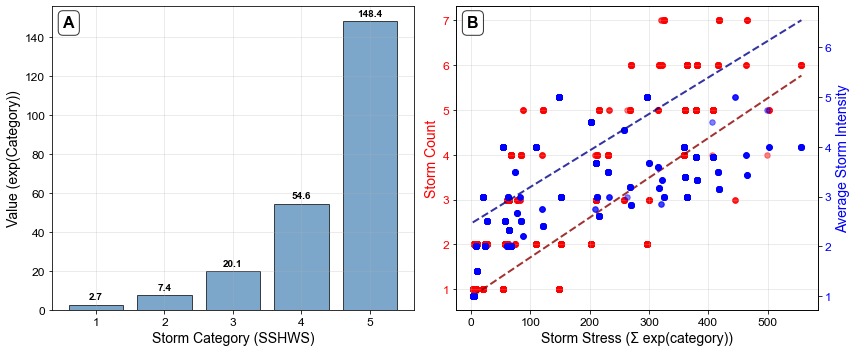

In [14]:
# Set font to Arial for all matplotlib text
plt.rcParams['font.family'] = 'Arial'

def create_storm_stress_explanation_figure(df):
    """
    Create a two-panel figure explaining storm stress calculation and showing real data patterns
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Panel 1: Storm category exponential values
    categories = np.array([1, 2, 3, 4, 5])
    exp_values = np.exp(categories)
    
    ax1.bar(categories, exp_values, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Storm Category (SSHWS)', fontsize=14)
    ax1.set_ylabel('Value (exp(Category))', fontsize=14)
    # ax1.set_title('Exponential Growth of Storm Stress\nby Category', fontsize=14, fontweight='bold')
    ax1.set_xticks(categories)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add panel label
    ax1.text(0.03, 0.97, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold',
             ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3",facecolor="white", alpha=0.8))  
    
    # Add value labels on bars
    for i, v in enumerate(exp_values):
        ax1.text(categories[i], v + max(exp_values) * 0.01, f'{v:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # Panel 2: Real data analysis
    # Calculate storm pressure (as defined in your code)
    def calculate_storm_pressure(row):
        if pd.isna(row['storm_intensities']) or row['storm_intensities'] == 'none' or row['storm_count'] == 0:
            return 0
        try:
            intensities = [float(x) for x in str(row['storm_intensities']).split(', ')]
            return sum(np.exp(intensity) for intensity in intensities)
        except:
            return 0
    
    # Calculate average storm intensity
    def calculate_avg_storm_intensity(row):
        if pd.isna(row['storm_intensities']) or row['storm_intensities'] == 'none' or row['storm_count'] == 0:
            return 0
        try:
            intensities = [float(x) for x in str(row['storm_intensities']).split(', ')]
            return np.mean(intensities)
        except:
            return 0
    
    # Apply calculations
    df_plot = df.copy()
    df_plot['storm_pressure'] = df_plot.apply(calculate_storm_pressure, axis=1)
    df_plot['avg_storm_intensity'] = df_plot.apply(calculate_avg_storm_intensity, axis=1)
    
    # Filter out seascapes with no storms for cleaner visualization
    storm_data = df_plot[df_plot['storm_count'] > 0].copy()
    
    if len(storm_data) > 0:
        # Create twin axis for the second y-axis
        ax2_twin = ax2.twinx()
        
        # Plot each seascape once with storm count and average intensity as the two y-values
        scatter = ax2.scatter(storm_data['storm_pressure'], storm_data['storm_count'], 
                             alpha=0.5, color='red', s=30, label='Storm Count')
        
        scatter_twin = ax2_twin.scatter(storm_data['storm_pressure'], storm_data['avg_storm_intensity'], 
                                       alpha=0.5, color='blue', s=30, label='Avg Storm Intensity')
        
        # Set labels and titles
        ax2.set_xlabel('Storm Stress (Σ exp(category))', fontsize=14)
        ax2.set_ylabel('Storm Count', fontsize=14, color='red')
        ax2_twin.set_ylabel('Average Storm Intensity', fontsize=14, color='blue')
        # ax2.set_title('Real Data: Storm Stress vs.\nCount and Intensity', fontsize=14, fontweight='bold')
        
        # Color the y-axis labels to match the data
        ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
        ax2_twin.tick_params(axis='y', labelcolor='blue', labelsize=12)
        ax2.tick_params(axis='x', labelsize=12)
        
        # Add grid
        ax2.grid(True, alpha=0.3)
        
        # Add trendlines
        if len(storm_data) > 1:
            # Trendline for storm count (red)
            z_count = np.polyfit(storm_data['storm_pressure'], storm_data['storm_count'], 1)
            p_count = np.poly1d(z_count)
            x_range = np.linspace(storm_data['storm_pressure'].min(), storm_data['storm_pressure'].max(), 100)
            ax2.plot(x_range, p_count(x_range), '--', color='darkred', alpha=0.8, linewidth=2)
            
            # Trendline for average storm intensity (blue)
            z_avg = np.polyfit(storm_data['storm_pressure'], storm_data['avg_storm_intensity'], 1)
            p_avg = np.poly1d(z_avg)
            ax2_twin.plot(x_range, p_avg(x_range), '--', color='darkblue', alpha=0.8, linewidth=2)
        
        # Add panel label
        ax2.text(0.03, 0.97, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold',
                 ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Set x-axis to log scale if there's a wide range
        storm_pressure_range = storm_data['storm_pressure'].max() - storm_data['storm_pressure'].min()
        if storm_pressure_range > 1000:
            ax2.set_xscale('log')
    else:
        ax2.text(0.5, 0.5, 'No storm data available', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12)
    
    plt.tight_layout()
    return fig

# Load data and create figure
def main():
    # Load the data
    df = pd.read_csv('all_regions_combined_v3.csv')
    
    # Create the explanation figure
    fig = create_storm_stress_explanation_figure(df)
    
    # Save the figure
    fig.savefig('storm_stress_explanation.png', dpi=300, bbox_inches='tight')
    # fig.savefig('storm_stress_explanation.svg', bbox_inches='tight')
    
    plt.show()
    
    return fig

if __name__ == "__main__":
    fig = main()